In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline


In [8]:
import os
def readImages(dir, pattern):
    """
    Returns an image list with the image contained on the directory `dir` matching the `pattern`.
    """
    images = []
    for dirpath, dirnames, filenames in os.walk(dir):
        for dirname in dirnames:
            images.append(glob.glob(dir + '/' + dirname + '/' + pattern))
    flatten = [item for sublist in images for item in sublist]
    return list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), flatten))

vehicles = readImages('.\\code\\vehicles', '*.png')
non_vehicles = readImages('.\\code\\non-vehicles', '*.png')

Vehicle train image count: 8792
Non-vehicle train image count: 8968


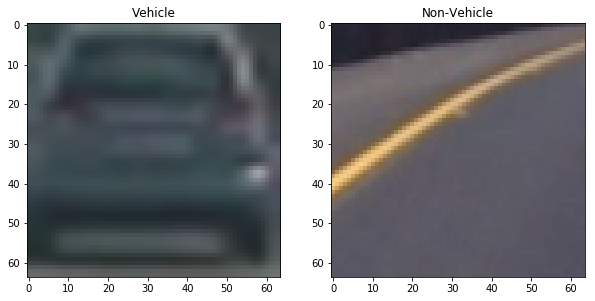

In [9]:
index = 10
vehicle = vehicles[index]
non_vehicle = non_vehicles[index]

fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
axes[0].imshow(vehicle)
axes[0].set_title('Vehicle')
axes[1].imshow(non_vehicle)
axes[1].set_title('Non-Vehicle')

print('Vehicle train image count: {}'.format(len(vehicles)))
print('Non-vehicle train image count: {}'.format(len(non_vehicles)))

In [10]:
# Basic functions provided on Udacity's course to extract features.

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Value object to hold all feature extraction parameters.
class FeaturesParameters():
    def __init__(self):
        # HOG parameters
        self.cspace = 'YCrCb'
        self.orient = 8
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.hog_channel = 'ALL'
        # Bin spatial parameters
        self.size = (16, 16)
        # Histogram parameters
        self.hist_bins = 32
        self.hist_range = (0, 256)
        
def extract_features(image, params ):
    # Parameters extraction
    # HOG parameters
    cspace = params.cspace
    orient = params.orient
    pix_per_cell = params.pix_per_cell
    cell_per_block = params.cell_per_block
    hog_channel = params.hog_channel
    # Spatial parameters
    size = params.size
    # Histogram parameters
    hist_bins = params.hist_bins
    hist_range = params.hist_range
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)

    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size)

    # Apply color_hist() 
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    
    return np.concatenate((spatial_features, hist_features, hog_features))

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time

def fitModel( positive, negative, svc, scaler, params ):
    """
    Trains the classifier `svc`. The feature extraction is done using the parameters stored in `params`.
    The feature scalling is done by the scaler `scaler`.
    Returns: (`svc`, fittingTime, accuracy)
    """
    positive_features = list(map(lambda img: extract_features(img, params), positive))
    negatice_features = list(map(lambda img: extract_features(img, params), negative))
    
    # Stacking and scaling
    X = np.vstack((positive_features, negatice_features)).astype(np.float64)    
    X_scaler = scaler.fit(X)
    scaled_X = X_scaler.transform(X)
    
    # Defining objective
    y = np.hstack((np.ones(len(positive_features)), np.zeros(len(negatice_features))))
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
    
    # Fitting
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    
    fittingTime = round(t2 - t, 2)
    accuracy = round(svc.score(X_test, y_test),4)
    return (svc, X_scaler, fittingTime, accuracy)

In [13]:
from sklearn.svm import LinearSVC

params = FeaturesParameters()
svc, scaler, fittingTime, accuracy = fitModel(vehicles, non_vehicles, LinearSVC(), StandardScaler(), params)
print('Fitting time: {} s, Accuracy: {}'.format(fittingTime, accuracy))

C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Fitting time: 4.01 s, Accuracy: 0.993


C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


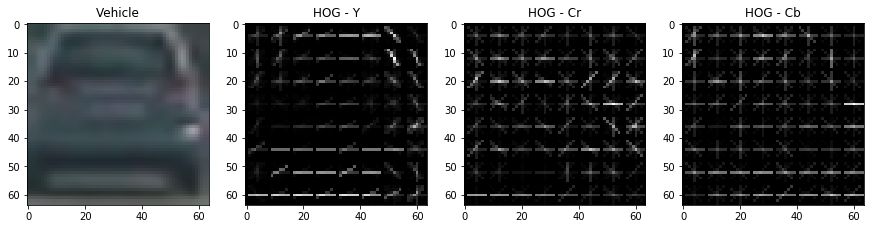

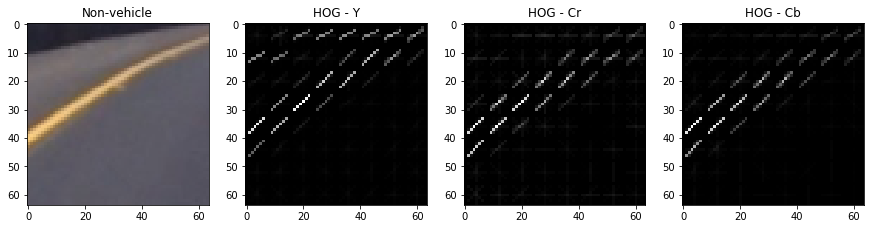

In [15]:
def showHOG(img, title):
    """
    Calculate HOG on the image `img` and the YCrCb color space and show them on a graph.
    """
    img_cspaced = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    _, hog_y = get_hog_features(img_cspaced[:,:,0], 
                                    params.orient, params.pix_per_cell, params.cell_per_block, 
                                    vis=True, feature_vec=True)
    _, hog_Cr = get_hog_features(img_cspaced[:,:,1], 
                                    params.orient, params.pix_per_cell, params.cell_per_block, 
                                    vis=True, feature_vec=True)
    _, hog_Cb = get_hog_features(img_cspaced[:,:,2], 
                                    params.orient, params.pix_per_cell, params.cell_per_block, 
                                    vis=True, feature_vec=True)

    fig, axes = plt.subplots(ncols=4, figsize=(15,15))
    axes[0].imshow(img)
    axes[0].set_title(title)
    axes[1].imshow(hog_y, cmap='gray')
    axes[1].set_title('HOG - Y')
    axes[2].imshow(hog_Cr, cmap='gray')
    axes[2].set_title('HOG - Cr')
    axes[3].imshow(hog_Cb, cmap='gray')
    axes[3].set_title('HOG - Cb')

showHOG(vehicle, 'Vehicle')
showHOG(non_vehicle, 'Non-vehicle')

In [16]:
# Basic functions provided on Udacity's course to creating windows and drawing boxes on an image.
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [17]:
test_images = list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), glob.glob('./test_images/*.jpg')))


In [18]:
def findCarWindows(img, clf, scaler, params, y_start_stop=[360, 700], xy_window=(64, 64), xy_overlap=(0.85, 0.85) ):
    """
    Returns the windows where the cars are found on the image `img`.
    The feature extraction used parameters `params`.
    `y_start_stop` : Contains the Y axis range to find the cars.
    `xy_window` : Contains the windows size.
    `xy_overlap` : Contains the windows overlap percent.
    Returns a new image with the cars boxes.
    """
    car_windows = []
    windows = slide_window(img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
    for window in windows:
        img_window = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = extract_features(img_window, params)
        scaled_features = scaler.transform(features.reshape(1, -1))
        pred = clf.predict(scaled_features)
        if pred == 1:
            car_windows.append(window)
    return car_windows

def drawCars(img, windows):
    """
    Draw the `windows` on the image `img`.
    """
    output = np.copy(img)
    return draw_boxes(output, windows)

In [20]:
car_on_test = list(map(lambda img: drawCars(img, findCarWindows(img, svc, scaler, params)), test_images))

C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


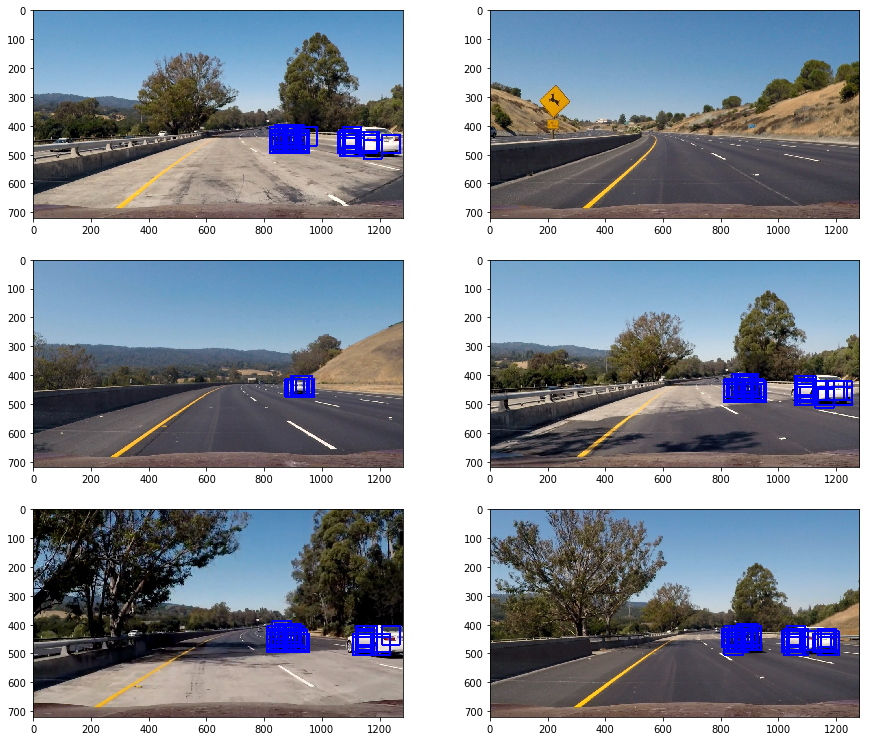

In [22]:
def showImages(images, cols = 2, rows = 3, figsize=(15,13)):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            image = images[index]
            ax.imshow(image)
            
showImages(car_on_test)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


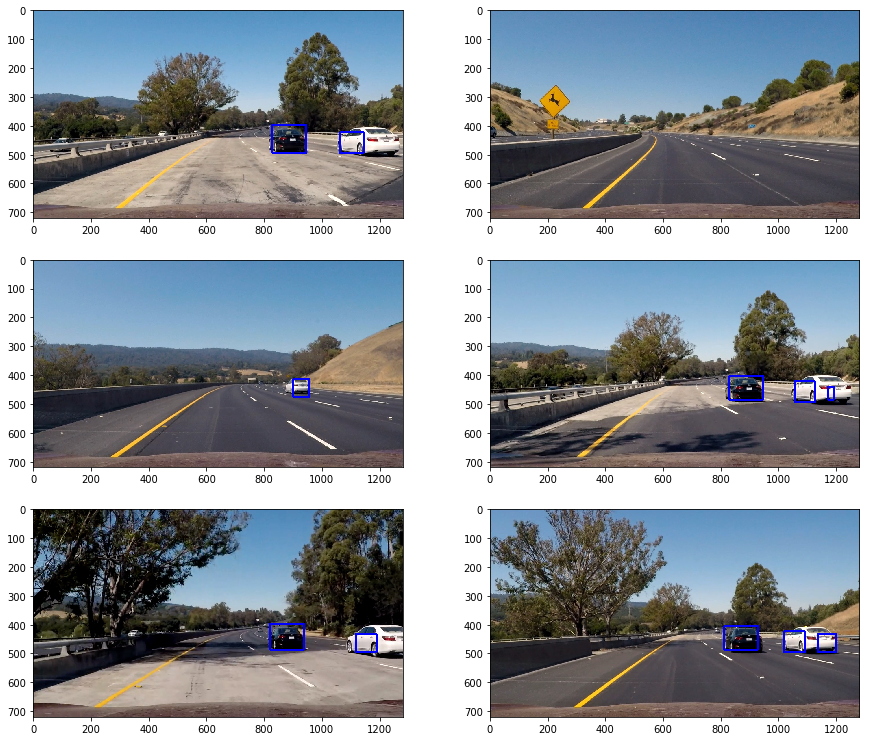

In [25]:
# Heat map and threshold functions from Udacity's course

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

from scipy.ndimage.measurements import label

def drawCarsWithLabels(img, boxes, threshHold = 4):
    """
    Draw the car boxes `boxes` on the image `img` using a heatmap with threshold `threshHold`.
    """
    heatmap = add_heat(np.zeros(img.shape), boxes)
    heatmap = apply_threshold(heatmap, threshHold)
    labels = label(heatmap)
    
    return draw_labeled_bboxes(np.copy(img), labels)
    
boxed_on_test = list(map(lambda img: drawCarsWithLabels(img, findCarWindows(img, svc, scaler, params)), test_images))

showImages(boxed_on_test)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


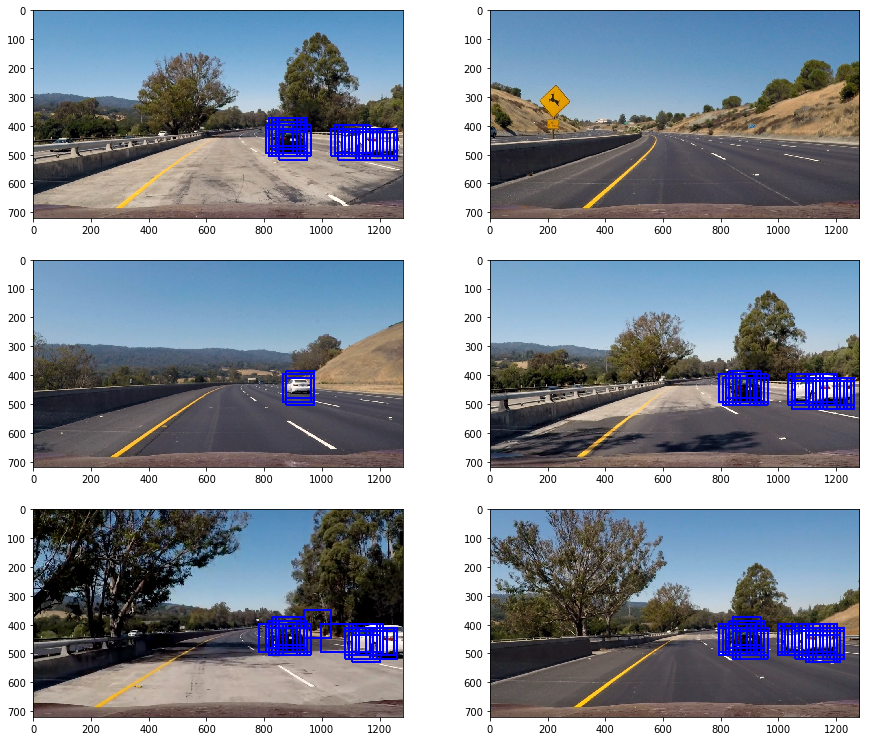

In [27]:
def findBoxes(img, clf, scaler, params, y_start_stop=[350, 656], window=64, cells_per_step=1, scale=1.5 ):
    """
    Returns the windows where the cars are found on the image `img`.
    The feature extraction used parameters `params`.
    `y_start_stop` : Contains the Y axis range to find the cars.
    `window` : Number of windows.
    `cells_per_step` : Number of cells per step.
    Returns a new image with the cars boxes.
    """
    # Parameters extraction
    # HOG parameters
    cspace = params.cspace
    orient = params.orient
    pix_per_cell = params.pix_per_cell
    cell_per_block = params.cell_per_block
    hog_channel = params.hog_channel
    # Spatial parameters
    size = params.size
    # Histogram parameters
    hist_bins = params.hist_bins
    hist_range = params.hist_range
    
    
    # Image color space changes
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    
    ystart, ystop = y_start_stop
    ctrans_tosearch = feature_image[ystart:ystop,:,:]
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    car_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=size)
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)
            
            # Scale features and make a prediction
            test_features = scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return car_windows

fast_boxes = list(map(lambda img: findBoxes(img, svc, scaler, params), test_images))

fast_on_test = list(map(lambda imgAndBox: drawCars(imgAndBox[0], imgAndBox[1]), zip(test_images, fast_boxes)))

showImages(fast_on_test)

In [29]:
from moviepy.editor import VideoFileClip
from functools import reduce

class HeatHistory():
    def __init__(self):
        self.history = []

def processVideo(inputVideo, outputVideo, frames_to_remember=3, threshhold=1):
    """
    Process the video `inputVideo` to find the cars and saves the video to `outputVideo`.
    """
    history = HeatHistory()

    def pipeline(img):
        boxes = findBoxes(img, svc, scaler, params)
        img_shape = img.shape
        heatmap = add_heat(np.zeros(img_shape), boxes)
        if len(history.history) >= frames_to_remember:
            history.history = history.history[1:]

        history.history.append(heatmap)
        heat_history = reduce(lambda h, acc: h + acc, history.history)/frames_to_remember
        heatmap = apply_threshold(heat_history, threshhold)
        labels = label(heatmap)

        return draw_labeled_bboxes(np.copy(img), labels)

    myclip = VideoFileClip(inputVideo)
    output_video = myclip.fl_image(pipeline)
    output_video.write_videofile(outputVideo, audio=False)
    
processVideo('.\\videos\\project_video.mp4', '.\\videos\\output_video.mp4', threshhold=2)

[MoviePy] >>>> Building video .\videos\output_video.mp4


[MoviePy] Writing video .\videos\output_video.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:01<27:52,  1.33s/it]

  0%|          | 2/1261 [00:02<27:38,  1.32s/it]

  0%|          | 3/1261 [00:03<26:56,  1.28s/it]

  0%|          | 4/1261 [00:05<26:13,  1.25s/it]

  0%|          | 5/1261 [00:06<26:07,  1.25s/it]

  0%|          | 6/1261 [00:07<25:40,  1.23s/it]

  1%|          | 7/1261 [00:08<25:33,  1.22s/it]

  1%|          | 8/1261 [00:09<25:31,  1.22s/it]

  1%|          | 9/1261 [00:11<25:20,  1.21s/it]

  1%|          | 10/1261 [00:12<25:12,  1.21s/it]

  1%|          | 11/1261 [00:13<25:05,  1.20s/it]

  1%|          | 12/1261 [00:14<25:19,  1.22s/it]

  1%|          | 13/1261 [00:15<25:13,  1.21s/it]

  1%|          | 14/1261 [00:17<25:09,  1.21s/it]

  1%|          | 15/1261 [00:18<25:18,  1.22s/it]

  1%|▏         | 16/1261 [00:19<25:13,  1.22s/it]

  1%|▏         | 17/1261 [00:20<25:20,  1.22s/it]

  1%|▏         | 18/1261 [00:22<25:31,  1.23s/it]

  2%|▏         | 19/1261 [00:23<25:22,  1.23s/it]

  2%|▏         | 20/1261 [00:24<25:24,  1.23s/it]

  2%|▏         | 21/1261 [00:25<25:26,  1.23s/it]

  2%|▏         | 22/1261 [00:26<25:41,  1.24s/it]

  2%|▏         | 23/1261 [00:28<25:40,  1.24s/it]

  2%|▏         | 24/1261 [00:29<25:38,  1.24s/it]

  2%|▏         | 25/1261 [00:30<25:47,  1.25s/it]

  2%|▏         | 26/1261 [00:31<25:29,  1.24s/it]

  2%|▏         | 27/1261 [00:33<25:28,  1.24s/it]

  2%|▏         | 28/1261 [00:34<25:16,  1.23s/it]

  2%|▏         | 29/1261 [00:35<25:06,  1.22s/it]

  2%|▏         | 30/1261 [00:36<24:58,  1.22s/it]

  2%|▏         | 31/1261 [00:38<24:57,  1.22s/it]

  3%|▎         | 32/1261 [00:39<24:44,  1.21s/it]

  3%|▎         | 33/1261 [00:40<24:39,  1.20s/it]

  3%|▎         | 34/1261 [00:41<24:37,  1.20s/it]

  3%|▎         | 35/1261 [00:42<24:48,  1.21s/it]

  3%|▎         | 36/1261 [00:44<24:53,  1.22s/it]

  3%|▎         | 37/1261 [00:45<24:46,  1.21s/it]

  3%|▎         | 38/1261 [00:46<24:46,  1.22s/it]

  3%|▎         | 39/1261 [00:47<24:44,  1.21s/it]

  3%|▎         | 40/1261 [00:48<24:39,  1.21s/it]

  3%|▎         | 41/1261 [00:50<24:45,  1.22s/it]

  3%|▎         | 42/1261 [00:51<24:35,  1.21s/it]

  3%|▎         | 43/1261 [00:52<24:43,  1.22s/it]

  3%|▎         | 44/1261 [00:53<24:34,  1.21s/it]

  4%|▎         | 45/1261 [00:55<24:43,  1.22s/it]

  4%|▎         | 46/1261 [00:56<24:37,  1.22s/it]

  4%|▎         | 47/1261 [00:57<24:36,  1.22s/it]

  4%|▍         | 48/1261 [00:58<24:44,  1.22s/it]

  4%|▍         | 49/1261 [00:59<24:43,  1.22s/it]

  4%|▍         | 50/1261 [01:01<24:45,  1.23s/it]

  4%|▍         | 51/1261 [01:02<24:34,  1.22s/it]

  4%|▍         | 52/1261 [01:03<24:36,  1.22s/it]

  4%|▍         | 53/1261 [01:04<24:31,  1.22s/it]

  4%|▍         | 54/1261 [01:06<24:39,  1.23s/it]

  4%|▍         | 55/1261 [01:07<24:47,  1.23s/it]

  4%|▍         | 56/1261 [01:08<24:46,  1.23s/it]

  5%|▍         | 57/1261 [01:09<24:46,  1.23s/it]

  5%|▍         | 58/1261 [01:11<24:57,  1.25s/it]

  5%|▍         | 59/1261 [01:12<24:56,  1.24s/it]

  5%|▍         | 60/1261 [01:13<25:04,  1.25s/it]

  5%|▍         | 61/1261 [01:14<25:01,  1.25s/it]

  5%|▍         | 62/1261 [01:16<24:55,  1.25s/it]

  5%|▍         | 63/1261 [01:17<24:51,  1.24s/it]

  5%|▌         | 64/1261 [01:18<24:37,  1.23s/it]

  5%|▌         | 65/1261 [01:19<24:18,  1.22s/it]

  5%|▌         | 66/1261 [01:20<24:18,  1.22s/it]

  5%|▌         | 67/1261 [01:22<24:13,  1.22s/it]

  5%|▌         | 68/1261 [01:23<24:09,  1.21s/it]

  5%|▌         | 69/1261 [01:24<24:08,  1.22s/it]

  6%|▌         | 70/1261 [01:25<24:05,  1.21s/it]

  6%|▌         | 71/1261 [01:26<24:20,  1.23s/it]

  6%|▌         | 72/1261 [01:28<24:09,  1.22s/it]

  6%|▌         | 73/1261 [01:29<24:11,  1.22s/it]

  6%|▌         | 74/1261 [01:30<24:34,  1.24s/it]

  6%|▌         | 75/1261 [01:31<24:48,  1.26s/it]

  6%|▌         | 76/1261 [01:33<24:44,  1.25s/it]

  6%|▌         | 77/1261 [01:34<24:47,  1.26s/it]

  6%|▌         | 78/1261 [01:35<24:35,  1.25s/it]

  6%|▋         | 79/1261 [01:36<24:38,  1.25s/it]

  6%|▋         | 80/1261 [01:38<24:38,  1.25s/it]

  6%|▋         | 81/1261 [01:39<25:09,  1.28s/it]

  7%|▋         | 82/1261 [01:40<24:44,  1.26s/it]

  7%|▋         | 83/1261 [01:42<25:04,  1.28s/it]

  7%|▋         | 84/1261 [01:43<25:22,  1.29s/it]

  7%|▋         | 85/1261 [01:44<25:11,  1.29s/it]

  7%|▋         | 86/1261 [01:45<24:51,  1.27s/it]

  7%|▋         | 87/1261 [01:47<24:44,  1.26s/it]

  7%|▋         | 88/1261 [01:48<24:20,  1.25s/it]

  7%|▋         | 89/1261 [01:49<24:16,  1.24s/it]

  7%|▋         | 90/1261 [01:50<24:24,  1.25s/it]

  7%|▋         | 91/1261 [01:52<24:04,  1.23s/it]

  7%|▋         | 92/1261 [01:53<24:02,  1.23s/it]

  7%|▋         | 93/1261 [01:54<24:25,  1.25s/it]

  7%|▋         | 94/1261 [01:55<24:34,  1.26s/it]

  8%|▊         | 95/1261 [01:57<24:36,  1.27s/it]

  8%|▊         | 96/1261 [01:58<24:50,  1.28s/it]

  8%|▊         | 97/1261 [01:59<24:26,  1.26s/it]

  8%|▊         | 98/1261 [02:00<24:15,  1.25s/it]

  8%|▊         | 99/1261 [02:02<24:09,  1.25s/it]

  8%|▊         | 100/1261 [02:03<24:06,  1.25s/it]

  8%|▊         | 101/1261 [02:04<23:49,  1.23s/it]

  8%|▊         | 102/1261 [02:05<24:02,  1.24s/it]

  8%|▊         | 103/1261 [02:07<23:52,  1.24s/it]

  8%|▊         | 104/1261 [02:08<23:28,  1.22s/it]

  8%|▊         | 105/1261 [02:09<23:19,  1.21s/it]

  8%|▊         | 106/1261 [02:10<23:32,  1.22s/it]

  8%|▊         | 107/1261 [02:11<23:33,  1.22s/it]

  9%|▊         | 108/1261 [02:13<23:28,  1.22s/it]

  9%|▊         | 109/1261 [02:14<23:35,  1.23s/it]

  9%|▊         | 110/1261 [02:15<23:24,  1.22s/it]

  9%|▉         | 111/1261 [02:16<23:24,  1.22s/it]

  9%|▉         | 112/1261 [02:18<23:26,  1.22s/it]

  9%|▉         | 113/1261 [02:19<23:11,  1.21s/it]

  9%|▉         | 114/1261 [02:20<23:08,  1.21s/it]

  9%|▉         | 115/1261 [02:21<23:26,  1.23s/it]

  9%|▉         | 116/1261 [02:22<23:25,  1.23s/it]

  9%|▉         | 117/1261 [02:24<23:30,  1.23s/it]

  9%|▉         | 118/1261 [02:25<23:26,  1.23s/it]

  9%|▉         | 119/1261 [02:26<23:32,  1.24s/it]

 10%|▉         | 120/1261 [02:27<23:28,  1.23s/it]

 10%|▉         | 121/1261 [02:29<23:50,  1.25s/it]

 10%|▉         | 122/1261 [02:30<23:46,  1.25s/it]

 10%|▉         | 123/1261 [02:31<23:44,  1.25s/it]

 10%|▉         | 124/1261 [02:32<23:50,  1.26s/it]

 10%|▉         | 125/1261 [02:34<23:45,  1.25s/it]

 10%|▉         | 126/1261 [02:35<23:36,  1.25s/it]

 10%|█         | 127/1261 [02:36<23:33,  1.25s/it]

 10%|█         | 128/1261 [02:37<23:29,  1.24s/it]

 10%|█         | 129/1261 [02:39<23:36,  1.25s/it]

 10%|█         | 130/1261 [02:40<23:20,  1.24s/it]

 10%|█         | 131/1261 [02:41<23:21,  1.24s/it]

 10%|█         | 132/1261 [02:42<23:22,  1.24s/it]

 11%|█         | 133/1261 [02:44<23:13,  1.24s/it]

 11%|█         | 134/1261 [02:45<23:10,  1.23s/it]

 11%|█         | 135/1261 [02:46<23:06,  1.23s/it]

 11%|█         | 136/1261 [02:47<23:00,  1.23s/it]

 11%|█         | 137/1261 [02:49<22:47,  1.22s/it]

 11%|█         | 138/1261 [02:50<22:46,  1.22s/it]

 11%|█         | 139/1261 [02:51<22:45,  1.22s/it]

 11%|█         | 140/1261 [02:52<22:34,  1.21s/it]

 11%|█         | 141/1261 [02:53<22:40,  1.21s/it]

 11%|█▏        | 142/1261 [02:55<22:58,  1.23s/it]

 11%|█▏        | 143/1261 [02:56<23:00,  1.24s/it]

 11%|█▏        | 144/1261 [02:57<22:44,  1.22s/it]

 11%|█▏        | 145/1261 [02:58<22:43,  1.22s/it]

 12%|█▏        | 146/1261 [02:59<22:34,  1.21s/it]

 12%|█▏        | 147/1261 [03:01<22:40,  1.22s/it]

 12%|█▏        | 148/1261 [03:02<22:42,  1.22s/it]

 12%|█▏        | 149/1261 [03:03<22:51,  1.23s/it]

 12%|█▏        | 150/1261 [03:04<23:04,  1.25s/it]

 12%|█▏        | 151/1261 [03:06<23:27,  1.27s/it]

 12%|█▏        | 152/1261 [03:07<23:51,  1.29s/it]

 12%|█▏        | 153/1261 [03:08<24:06,  1.31s/it]

 12%|█▏        | 154/1261 [03:10<24:31,  1.33s/it]

 12%|█▏        | 155/1261 [03:11<24:46,  1.34s/it]

 12%|█▏        | 156/1261 [03:12<24:03,  1.31s/it]

 12%|█▏        | 157/1261 [03:14<23:42,  1.29s/it]

 13%|█▎        | 158/1261 [03:15<23:16,  1.27s/it]

 13%|█▎        | 159/1261 [03:16<22:54,  1.25s/it]

 13%|█▎        | 160/1261 [03:17<22:43,  1.24s/it]

 13%|█▎        | 161/1261 [03:19<22:50,  1.25s/it]

 13%|█▎        | 162/1261 [03:20<22:52,  1.25s/it]

 13%|█▎        | 163/1261 [03:21<22:54,  1.25s/it]

 13%|█▎        | 164/1261 [03:22<22:54,  1.25s/it]

 13%|█▎        | 165/1261 [03:24<23:03,  1.26s/it]

 13%|█▎        | 166/1261 [03:25<23:00,  1.26s/it]

 13%|█▎        | 167/1261 [03:26<23:03,  1.26s/it]

 13%|█▎        | 168/1261 [03:27<22:48,  1.25s/it]

 13%|█▎        | 169/1261 [03:29<22:47,  1.25s/it]

 13%|█▎        | 170/1261 [03:30<22:45,  1.25s/it]

 14%|█▎        | 171/1261 [03:31<22:46,  1.25s/it]

 14%|█▎        | 172/1261 [03:32<22:51,  1.26s/it]

 14%|█▎        | 173/1261 [03:34<22:42,  1.25s/it]

 14%|█▍        | 174/1261 [03:35<22:31,  1.24s/it]

 14%|█▍        | 175/1261 [03:36<22:14,  1.23s/it]

 14%|█▍        | 176/1261 [03:37<22:23,  1.24s/it]

 14%|█▍        | 177/1261 [03:39<22:24,  1.24s/it]

 14%|█▍        | 178/1261 [03:40<22:20,  1.24s/it]

 14%|█▍        | 179/1261 [03:41<22:15,  1.23s/it]

 14%|█▍        | 180/1261 [03:42<22:20,  1.24s/it]

 14%|█▍        | 181/1261 [03:44<22:07,  1.23s/it]

 14%|█▍        | 182/1261 [03:45<21:58,  1.22s/it]

 15%|█▍        | 183/1261 [03:46<21:55,  1.22s/it]

 15%|█▍        | 184/1261 [03:47<21:54,  1.22s/it]

 15%|█▍        | 185/1261 [03:48<21:57,  1.22s/it]

 15%|█▍        | 186/1261 [03:50<21:50,  1.22s/it]

 15%|█▍        | 187/1261 [03:51<21:59,  1.23s/it]

 15%|█▍        | 188/1261 [03:52<21:59,  1.23s/it]

 15%|█▍        | 189/1261 [03:53<21:54,  1.23s/it]

 15%|█▌        | 190/1261 [03:55<21:53,  1.23s/it]

 15%|█▌        | 191/1261 [03:56<21:51,  1.23s/it]

 15%|█▌        | 192/1261 [03:57<22:04,  1.24s/it]

 15%|█▌        | 193/1261 [03:58<22:04,  1.24s/it]

 15%|█▌        | 194/1261 [04:00<22:00,  1.24s/it]

 15%|█▌        | 195/1261 [04:01<21:58,  1.24s/it]

 16%|█▌        | 196/1261 [04:02<22:05,  1.24s/it]

 16%|█▌        | 197/1261 [04:03<22:07,  1.25s/it]

 16%|█▌        | 198/1261 [04:05<22:10,  1.25s/it]

 16%|█▌        | 199/1261 [04:06<22:17,  1.26s/it]

 16%|█▌        | 200/1261 [04:07<22:22,  1.27s/it]

 16%|█▌        | 201/1261 [04:08<22:27,  1.27s/it]

 16%|█▌        | 202/1261 [04:10<22:17,  1.26s/it]

 16%|█▌        | 203/1261 [04:11<22:05,  1.25s/it]

 16%|█▌        | 204/1261 [04:12<21:48,  1.24s/it]

 16%|█▋        | 205/1261 [04:13<21:51,  1.24s/it]

 16%|█▋        | 206/1261 [04:15<21:54,  1.25s/it]

 16%|█▋        | 207/1261 [04:16<21:50,  1.24s/it]

 16%|█▋        | 208/1261 [04:17<21:46,  1.24s/it]

 17%|█▋        | 209/1261 [04:18<21:50,  1.25s/it]

 17%|█▋        | 210/1261 [04:20<21:43,  1.24s/it]

 17%|█▋        | 211/1261 [04:21<21:26,  1.22s/it]

 17%|█▋        | 212/1261 [04:22<21:26,  1.23s/it]

 17%|█▋        | 213/1261 [04:23<21:30,  1.23s/it]

 17%|█▋        | 214/1261 [04:24<21:25,  1.23s/it]

 17%|█▋        | 215/1261 [04:26<21:33,  1.24s/it]

 17%|█▋        | 216/1261 [04:27<21:30,  1.23s/it]

 17%|█▋        | 217/1261 [04:28<21:15,  1.22s/it]

 17%|█▋        | 218/1261 [04:29<21:20,  1.23s/it]

 17%|█▋        | 219/1261 [04:31<21:35,  1.24s/it]

 17%|█▋        | 220/1261 [04:32<21:29,  1.24s/it]

 18%|█▊        | 221/1261 [04:33<21:33,  1.24s/it]

 18%|█▊        | 222/1261 [04:34<21:40,  1.25s/it]

 18%|█▊        | 223/1261 [04:36<21:44,  1.26s/it]

 18%|█▊        | 224/1261 [04:37<22:12,  1.28s/it]

 18%|█▊        | 225/1261 [04:38<22:00,  1.27s/it]

 18%|█▊        | 226/1261 [04:39<21:28,  1.24s/it]

 18%|█▊        | 227/1261 [04:41<21:23,  1.24s/it]

 18%|█▊        | 228/1261 [04:42<21:18,  1.24s/it]

 18%|█▊        | 229/1261 [04:43<21:22,  1.24s/it]

 18%|█▊        | 230/1261 [04:44<21:13,  1.23s/it]

 18%|█▊        | 231/1261 [04:46<21:18,  1.24s/it]

 18%|█▊        | 232/1261 [04:47<22:41,  1.32s/it]

 18%|█▊        | 233/1261 [04:49<23:43,  1.38s/it]

 19%|█▊        | 234/1261 [04:50<23:17,  1.36s/it]

 19%|█▊        | 235/1261 [04:51<22:43,  1.33s/it]

 19%|█▊        | 236/1261 [04:52<22:12,  1.30s/it]

 19%|█▉        | 237/1261 [04:54<22:07,  1.30s/it]

 19%|█▉        | 238/1261 [04:55<22:08,  1.30s/it]

 19%|█▉        | 239/1261 [04:56<22:00,  1.29s/it]

 19%|█▉        | 240/1261 [04:58<21:48,  1.28s/it]

 19%|█▉        | 241/1261 [04:59<21:36,  1.27s/it]

 19%|█▉        | 242/1261 [05:00<21:22,  1.26s/it]

 19%|█▉        | 243/1261 [05:01<21:19,  1.26s/it]

 19%|█▉        | 244/1261 [05:03<21:29,  1.27s/it]

 19%|█▉        | 245/1261 [05:04<21:21,  1.26s/it]

 20%|█▉        | 246/1261 [05:05<20:56,  1.24s/it]

 20%|█▉        | 247/1261 [05:06<20:53,  1.24s/it]

 20%|█▉        | 248/1261 [05:07<21:01,  1.25s/it]

 20%|█▉        | 249/1261 [05:09<20:49,  1.23s/it]

 20%|█▉        | 250/1261 [05:10<20:37,  1.22s/it]

 20%|█▉        | 251/1261 [05:11<20:41,  1.23s/it]

 20%|█▉        | 252/1261 [05:12<20:30,  1.22s/it]

 20%|██        | 253/1261 [05:14<20:33,  1.22s/it]

 20%|██        | 254/1261 [05:15<20:31,  1.22s/it]

 20%|██        | 255/1261 [05:16<20:24,  1.22s/it]

 20%|██        | 256/1261 [05:17<20:17,  1.21s/it]

 20%|██        | 257/1261 [05:18<20:31,  1.23s/it]

 20%|██        | 258/1261 [05:20<20:29,  1.23s/it]

 21%|██        | 259/1261 [05:21<21:02,  1.26s/it]

 21%|██        | 260/1261 [05:22<20:58,  1.26s/it]

 21%|██        | 261/1261 [05:24<21:12,  1.27s/it]

 21%|██        | 262/1261 [05:25<21:01,  1.26s/it]

 21%|██        | 263/1261 [05:26<21:14,  1.28s/it]

 21%|██        | 264/1261 [05:28<23:17,  1.40s/it]

 21%|██        | 265/1261 [05:29<24:14,  1.46s/it]

 21%|██        | 266/1261 [05:31<25:33,  1.54s/it]

 21%|██        | 267/1261 [05:33<25:42,  1.55s/it]

 21%|██▏       | 268/1261 [05:34<24:11,  1.46s/it]

 21%|██▏       | 269/1261 [05:35<23:00,  1.39s/it]

 21%|██▏       | 270/1261 [05:36<22:13,  1.35s/it]

 21%|██▏       | 271/1261 [05:38<21:43,  1.32s/it]

 22%|██▏       | 272/1261 [05:39<21:08,  1.28s/it]

 22%|██▏       | 273/1261 [05:40<20:39,  1.25s/it]

 22%|██▏       | 274/1261 [05:41<20:05,  1.22s/it]

 22%|██▏       | 275/1261 [05:42<19:54,  1.21s/it]

 22%|██▏       | 276/1261 [05:44<19:48,  1.21s/it]

 22%|██▏       | 277/1261 [05:45<19:36,  1.20s/it]

 22%|██▏       | 278/1261 [05:46<19:26,  1.19s/it]

 22%|██▏       | 279/1261 [05:47<19:19,  1.18s/it]

 22%|██▏       | 280/1261 [05:48<19:32,  1.19s/it]

 22%|██▏       | 281/1261 [05:50<19:30,  1.19s/it]

 22%|██▏       | 282/1261 [05:51<19:24,  1.19s/it]

 22%|██▏       | 283/1261 [05:52<19:22,  1.19s/it]

 23%|██▎       | 284/1261 [05:53<19:11,  1.18s/it]

 23%|██▎       | 285/1261 [05:54<19:11,  1.18s/it]

 23%|██▎       | 286/1261 [05:55<19:27,  1.20s/it]

 23%|██▎       | 287/1261 [05:57<19:12,  1.18s/it]

 23%|██▎       | 288/1261 [05:58<19:33,  1.21s/it]

 23%|██▎       | 289/1261 [05:59<19:22,  1.20s/it]

 23%|██▎       | 290/1261 [06:00<19:07,  1.18s/it]

 23%|██▎       | 291/1261 [06:01<19:04,  1.18s/it]

 23%|██▎       | 292/1261 [06:03<19:26,  1.20s/it]

 23%|██▎       | 293/1261 [06:04<19:19,  1.20s/it]

 23%|██▎       | 294/1261 [06:05<19:13,  1.19s/it]

 23%|██▎       | 295/1261 [06:06<19:17,  1.20s/it]

 23%|██▎       | 296/1261 [06:07<19:16,  1.20s/it]

 24%|██▎       | 297/1261 [06:09<19:14,  1.20s/it]

 24%|██▎       | 298/1261 [06:10<19:23,  1.21s/it]

 24%|██▎       | 299/1261 [06:11<19:33,  1.22s/it]

 24%|██▍       | 300/1261 [06:12<19:24,  1.21s/it]

 24%|██▍       | 301/1261 [06:14<19:28,  1.22s/it]

 24%|██▍       | 302/1261 [06:15<19:35,  1.23s/it]

 24%|██▍       | 303/1261 [06:16<19:25,  1.22s/it]

 24%|██▍       | 304/1261 [06:17<19:21,  1.21s/it]

 24%|██▍       | 305/1261 [06:18<19:16,  1.21s/it]

 24%|██▍       | 306/1261 [06:20<19:20,  1.22s/it]

 24%|██▍       | 307/1261 [06:21<19:19,  1.22s/it]

 24%|██▍       | 308/1261 [06:22<19:12,  1.21s/it]

 25%|██▍       | 309/1261 [06:23<19:09,  1.21s/it]

 25%|██▍       | 310/1261 [06:24<19:09,  1.21s/it]

 25%|██▍       | 311/1261 [06:26<19:07,  1.21s/it]

 25%|██▍       | 312/1261 [06:27<19:01,  1.20s/it]

 25%|██▍       | 313/1261 [06:28<19:00,  1.20s/it]

 25%|██▍       | 314/1261 [06:29<18:55,  1.20s/it]

 25%|██▍       | 315/1261 [06:30<18:49,  1.19s/it]

 25%|██▌       | 316/1261 [06:32<18:45,  1.19s/it]

 25%|██▌       | 317/1261 [06:33<18:45,  1.19s/it]

 25%|██▌       | 318/1261 [06:34<18:38,  1.19s/it]

 25%|██▌       | 319/1261 [06:35<18:47,  1.20s/it]

 25%|██▌       | 320/1261 [06:36<18:46,  1.20s/it]

 25%|██▌       | 321/1261 [06:38<18:46,  1.20s/it]

 26%|██▌       | 322/1261 [06:39<19:04,  1.22s/it]

 26%|██▌       | 323/1261 [06:40<19:06,  1.22s/it]

 26%|██▌       | 324/1261 [06:41<18:52,  1.21s/it]

 26%|██▌       | 325/1261 [06:42<18:54,  1.21s/it]

 26%|██▌       | 326/1261 [06:44<18:51,  1.21s/it]

 26%|██▌       | 327/1261 [06:45<19:12,  1.23s/it]

 26%|██▌       | 328/1261 [06:46<18:54,  1.22s/it]

 26%|██▌       | 329/1261 [06:47<18:39,  1.20s/it]

 26%|██▌       | 330/1261 [06:49<18:42,  1.21s/it]

 26%|██▌       | 331/1261 [06:50<18:49,  1.21s/it]

 26%|██▋       | 332/1261 [06:51<19:11,  1.24s/it]

 26%|██▋       | 333/1261 [06:52<19:00,  1.23s/it]

 26%|██▋       | 334/1261 [06:53<18:50,  1.22s/it]

 27%|██▋       | 335/1261 [06:55<19:01,  1.23s/it]

 27%|██▋       | 336/1261 [06:56<18:59,  1.23s/it]

 27%|██▋       | 337/1261 [06:57<19:11,  1.25s/it]

 27%|██▋       | 338/1261 [06:59<19:22,  1.26s/it]

 27%|██▋       | 339/1261 [07:00<19:00,  1.24s/it]

 27%|██▋       | 340/1261 [07:01<18:47,  1.22s/it]

 27%|██▋       | 341/1261 [07:02<18:32,  1.21s/it]

 27%|██▋       | 342/1261 [07:03<18:25,  1.20s/it]

 27%|██▋       | 343/1261 [07:04<18:12,  1.19s/it]

 27%|██▋       | 344/1261 [07:06<17:55,  1.17s/it]

 27%|██▋       | 345/1261 [07:07<17:56,  1.17s/it]

 27%|██▋       | 346/1261 [07:08<17:58,  1.18s/it]

 28%|██▊       | 347/1261 [07:09<17:55,  1.18s/it]

 28%|██▊       | 348/1261 [07:10<18:06,  1.19s/it]

 28%|██▊       | 349/1261 [07:12<18:22,  1.21s/it]

 28%|██▊       | 350/1261 [07:13<18:11,  1.20s/it]

 28%|██▊       | 351/1261 [07:14<18:22,  1.21s/it]

 28%|██▊       | 352/1261 [07:15<18:33,  1.22s/it]

 28%|██▊       | 353/1261 [07:16<18:33,  1.23s/it]

 28%|██▊       | 354/1261 [07:18<18:39,  1.23s/it]

 28%|██▊       | 355/1261 [07:19<18:32,  1.23s/it]

 28%|██▊       | 356/1261 [07:20<18:28,  1.22s/it]

 28%|██▊       | 357/1261 [07:21<18:29,  1.23s/it]

 28%|██▊       | 358/1261 [07:23<18:13,  1.21s/it]

 28%|██▊       | 359/1261 [07:24<18:14,  1.21s/it]

 29%|██▊       | 360/1261 [07:25<18:03,  1.20s/it]

 29%|██▊       | 361/1261 [07:26<18:02,  1.20s/it]

 29%|██▊       | 362/1261 [07:27<18:12,  1.22s/it]

 29%|██▉       | 363/1261 [07:29<18:13,  1.22s/it]

 29%|██▉       | 364/1261 [07:30<18:25,  1.23s/it]

 29%|██▉       | 365/1261 [07:31<18:31,  1.24s/it]

 29%|██▉       | 366/1261 [07:32<18:37,  1.25s/it]

 29%|██▉       | 367/1261 [07:34<18:27,  1.24s/it]

 29%|██▉       | 368/1261 [07:35<18:29,  1.24s/it]

 29%|██▉       | 369/1261 [07:36<18:43,  1.26s/it]

 29%|██▉       | 370/1261 [07:37<18:50,  1.27s/it]

 29%|██▉       | 371/1261 [07:39<18:52,  1.27s/it]

 30%|██▉       | 372/1261 [07:40<18:43,  1.26s/it]

 30%|██▉       | 373/1261 [07:41<18:28,  1.25s/it]

 30%|██▉       | 374/1261 [07:42<18:41,  1.26s/it]

 30%|██▉       | 375/1261 [07:44<18:23,  1.25s/it]

 30%|██▉       | 376/1261 [07:45<18:34,  1.26s/it]

 30%|██▉       | 377/1261 [07:46<18:46,  1.27s/it]

 30%|██▉       | 378/1261 [07:48<18:34,  1.26s/it]

 30%|███       | 379/1261 [07:49<18:23,  1.25s/it]

 30%|███       | 380/1261 [07:50<18:20,  1.25s/it]

 30%|███       | 381/1261 [07:51<18:18,  1.25s/it]

 30%|███       | 382/1261 [07:53<18:30,  1.26s/it]

 30%|███       | 383/1261 [07:54<18:29,  1.26s/it]

 30%|███       | 384/1261 [07:55<18:28,  1.26s/it]

 31%|███       | 385/1261 [07:56<18:24,  1.26s/it]

 31%|███       | 386/1261 [07:58<18:14,  1.25s/it]

 31%|███       | 387/1261 [07:59<18:15,  1.25s/it]

 31%|███       | 388/1261 [08:00<18:07,  1.25s/it]

 31%|███       | 389/1261 [08:01<18:13,  1.25s/it]

 31%|███       | 390/1261 [08:03<18:15,  1.26s/it]

 31%|███       | 391/1261 [08:04<17:54,  1.24s/it]

 31%|███       | 392/1261 [08:05<17:54,  1.24s/it]

 31%|███       | 393/1261 [08:06<17:57,  1.24s/it]

 31%|███       | 394/1261 [08:08<18:11,  1.26s/it]

 31%|███▏      | 395/1261 [08:09<18:05,  1.25s/it]

 31%|███▏      | 396/1261 [08:10<18:15,  1.27s/it]

 31%|███▏      | 397/1261 [08:11<18:23,  1.28s/it]

 32%|███▏      | 398/1261 [08:13<18:17,  1.27s/it]

 32%|███▏      | 399/1261 [08:14<18:13,  1.27s/it]

 32%|███▏      | 400/1261 [08:15<18:30,  1.29s/it]

 32%|███▏      | 401/1261 [08:17<18:33,  1.30s/it]

 32%|███▏      | 402/1261 [08:18<18:29,  1.29s/it]

 32%|███▏      | 403/1261 [08:19<18:24,  1.29s/it]

 32%|███▏      | 404/1261 [08:20<18:24,  1.29s/it]

 32%|███▏      | 405/1261 [08:22<18:15,  1.28s/it]

 32%|███▏      | 406/1261 [08:23<18:09,  1.27s/it]

 32%|███▏      | 407/1261 [08:24<18:16,  1.28s/it]

 32%|███▏      | 408/1261 [08:26<18:18,  1.29s/it]

 32%|███▏      | 409/1261 [08:27<18:07,  1.28s/it]

 33%|███▎      | 410/1261 [08:28<18:07,  1.28s/it]

 33%|███▎      | 411/1261 [08:29<17:46,  1.25s/it]

 33%|███▎      | 412/1261 [08:31<17:42,  1.25s/it]

 33%|███▎      | 413/1261 [08:32<17:35,  1.24s/it]

 33%|███▎      | 414/1261 [08:33<17:43,  1.26s/it]

 33%|███▎      | 415/1261 [08:34<17:49,  1.26s/it]

 33%|███▎      | 416/1261 [08:36<17:43,  1.26s/it]

 33%|███▎      | 417/1261 [08:37<17:29,  1.24s/it]

 33%|███▎      | 418/1261 [08:38<17:30,  1.25s/it]

 33%|███▎      | 419/1261 [08:39<17:28,  1.25s/it]

 33%|███▎      | 420/1261 [08:41<17:25,  1.24s/it]

 33%|███▎      | 421/1261 [08:42<17:22,  1.24s/it]

 33%|███▎      | 422/1261 [08:43<17:25,  1.25s/it]

 34%|███▎      | 423/1261 [08:44<17:19,  1.24s/it]

 34%|███▎      | 424/1261 [08:45<17:13,  1.23s/it]

 34%|███▎      | 425/1261 [08:47<17:19,  1.24s/it]

 34%|███▍      | 426/1261 [08:48<17:20,  1.25s/it]

 34%|███▍      | 427/1261 [08:49<17:23,  1.25s/it]

 34%|███▍      | 428/1261 [08:50<17:23,  1.25s/it]

 34%|███▍      | 429/1261 [08:52<17:20,  1.25s/it]

 34%|███▍      | 430/1261 [08:53<17:23,  1.26s/it]

 34%|███▍      | 431/1261 [08:54<17:28,  1.26s/it]

 34%|███▍      | 432/1261 [08:56<17:25,  1.26s/it]

 34%|███▍      | 433/1261 [08:57<17:21,  1.26s/it]

 34%|███▍      | 434/1261 [08:58<17:22,  1.26s/it]

 34%|███▍      | 435/1261 [08:59<17:14,  1.25s/it]

 35%|███▍      | 436/1261 [09:01<17:09,  1.25s/it]

 35%|███▍      | 437/1261 [09:02<17:21,  1.26s/it]

 35%|███▍      | 438/1261 [09:03<17:27,  1.27s/it]

 35%|███▍      | 439/1261 [09:04<17:25,  1.27s/it]

 35%|███▍      | 440/1261 [09:06<17:22,  1.27s/it]

 35%|███▍      | 441/1261 [09:07<17:24,  1.27s/it]

 35%|███▌      | 442/1261 [09:08<17:20,  1.27s/it]

 35%|███▌      | 443/1261 [09:09<17:15,  1.27s/it]

 35%|███▌      | 444/1261 [09:11<17:09,  1.26s/it]

 35%|███▌      | 445/1261 [09:12<17:01,  1.25s/it]

 35%|███▌      | 446/1261 [09:13<16:53,  1.24s/it]

 35%|███▌      | 447/1261 [09:14<16:51,  1.24s/it]

 36%|███▌      | 448/1261 [09:16<16:42,  1.23s/it]

 36%|███▌      | 449/1261 [09:17<16:40,  1.23s/it]

 36%|███▌      | 450/1261 [09:18<16:34,  1.23s/it]

 36%|███▌      | 451/1261 [09:19<16:33,  1.23s/it]

 36%|███▌      | 452/1261 [09:20<16:31,  1.23s/it]

 36%|███▌      | 453/1261 [09:22<16:31,  1.23s/it]

 36%|███▌      | 454/1261 [09:23<16:32,  1.23s/it]

 36%|███▌      | 455/1261 [09:24<16:38,  1.24s/it]

 36%|███▌      | 456/1261 [09:26<16:52,  1.26s/it]

 36%|███▌      | 457/1261 [09:27<16:41,  1.25s/it]

 36%|███▋      | 458/1261 [09:28<16:41,  1.25s/it]

 36%|███▋      | 459/1261 [09:29<16:43,  1.25s/it]

 36%|███▋      | 460/1261 [09:30<16:37,  1.25s/it]

 37%|███▋      | 461/1261 [09:32<16:38,  1.25s/it]

 37%|███▋      | 462/1261 [09:33<16:36,  1.25s/it]

 37%|███▋      | 463/1261 [09:34<16:30,  1.24s/it]

 37%|███▋      | 464/1261 [09:35<16:26,  1.24s/it]

 37%|███▋      | 465/1261 [09:37<16:22,  1.23s/it]

 37%|███▋      | 466/1261 [09:38<16:22,  1.24s/it]

 37%|███▋      | 467/1261 [09:39<16:18,  1.23s/it]

 37%|███▋      | 468/1261 [09:40<16:24,  1.24s/it]

 37%|███▋      | 469/1261 [09:42<16:20,  1.24s/it]

 37%|███▋      | 470/1261 [09:43<16:25,  1.25s/it]

 37%|███▋      | 471/1261 [09:44<16:27,  1.25s/it]

 37%|███▋      | 472/1261 [09:45<16:17,  1.24s/it]

 38%|███▊      | 473/1261 [09:47<16:13,  1.24s/it]

 38%|███▊      | 474/1261 [09:48<16:23,  1.25s/it]

 38%|███▊      | 475/1261 [09:49<16:35,  1.27s/it]

 38%|███▊      | 476/1261 [09:50<16:37,  1.27s/it]

 38%|███▊      | 477/1261 [09:52<16:53,  1.29s/it]

 38%|███▊      | 478/1261 [09:53<16:45,  1.28s/it]

 38%|███▊      | 479/1261 [09:54<16:46,  1.29s/it]

 38%|███▊      | 480/1261 [09:56<16:34,  1.27s/it]

 38%|███▊      | 481/1261 [09:57<16:39,  1.28s/it]

 38%|███▊      | 482/1261 [09:58<16:22,  1.26s/it]

 38%|███▊      | 483/1261 [09:59<16:21,  1.26s/it]

 38%|███▊      | 484/1261 [10:01<16:19,  1.26s/it]

 38%|███▊      | 485/1261 [10:02<16:19,  1.26s/it]

 39%|███▊      | 486/1261 [10:03<16:19,  1.26s/it]

 39%|███▊      | 487/1261 [10:04<16:09,  1.25s/it]

 39%|███▊      | 488/1261 [10:06<16:16,  1.26s/it]

 39%|███▉      | 489/1261 [10:07<16:51,  1.31s/it]

 39%|███▉      | 490/1261 [10:08<16:45,  1.30s/it]

 39%|███▉      | 491/1261 [10:10<16:45,  1.31s/it]

 39%|███▉      | 492/1261 [10:11<16:28,  1.29s/it]

 39%|███▉      | 493/1261 [10:12<16:24,  1.28s/it]

 39%|███▉      | 494/1261 [10:14<16:31,  1.29s/it]

 39%|███▉      | 495/1261 [10:15<16:22,  1.28s/it]

 39%|███▉      | 496/1261 [10:16<16:13,  1.27s/it]

 39%|███▉      | 497/1261 [10:17<15:51,  1.25s/it]

 39%|███▉      | 498/1261 [10:18<15:41,  1.23s/it]

 40%|███▉      | 499/1261 [10:20<15:45,  1.24s/it]

 40%|███▉      | 500/1261 [10:21<15:43,  1.24s/it]

 40%|███▉      | 501/1261 [10:22<15:27,  1.22s/it]

 40%|███▉      | 502/1261 [10:23<15:42,  1.24s/it]

 40%|███▉      | 503/1261 [10:25<15:38,  1.24s/it]

 40%|███▉      | 504/1261 [10:26<15:51,  1.26s/it]

 40%|████      | 505/1261 [10:27<16:00,  1.27s/it]

 40%|████      | 506/1261 [10:28<15:51,  1.26s/it]

 40%|████      | 507/1261 [10:30<16:47,  1.34s/it]

 40%|████      | 508/1261 [10:31<16:54,  1.35s/it]

 40%|████      | 509/1261 [10:33<17:26,  1.39s/it]

 40%|████      | 510/1261 [10:34<17:31,  1.40s/it]

 41%|████      | 511/1261 [10:36<17:10,  1.37s/it]

 41%|████      | 512/1261 [10:37<16:50,  1.35s/it]

 41%|████      | 513/1261 [10:38<16:30,  1.32s/it]

 41%|████      | 514/1261 [10:39<16:14,  1.30s/it]

 41%|████      | 515/1261 [10:41<16:00,  1.29s/it]

 41%|████      | 516/1261 [10:42<16:09,  1.30s/it]

 41%|████      | 517/1261 [10:43<16:13,  1.31s/it]

 41%|████      | 518/1261 [10:45<16:11,  1.31s/it]

 41%|████      | 519/1261 [10:46<17:06,  1.38s/it]

 41%|████      | 520/1261 [10:48<17:42,  1.43s/it]

 41%|████▏     | 521/1261 [10:49<16:47,  1.36s/it]

 41%|████▏     | 522/1261 [10:50<16:09,  1.31s/it]

 41%|████▏     | 523/1261 [10:51<15:54,  1.29s/it]

 42%|████▏     | 524/1261 [10:53<15:25,  1.26s/it]

 42%|████▏     | 525/1261 [10:54<15:09,  1.24s/it]

 42%|████▏     | 526/1261 [10:55<15:16,  1.25s/it]

 42%|████▏     | 527/1261 [10:56<15:08,  1.24s/it]

 42%|████▏     | 528/1261 [10:57<15:15,  1.25s/it]

 42%|████▏     | 529/1261 [10:59<15:21,  1.26s/it]

 42%|████▏     | 530/1261 [11:00<15:16,  1.25s/it]

 42%|████▏     | 531/1261 [11:01<15:04,  1.24s/it]

 42%|████▏     | 532/1261 [11:02<15:05,  1.24s/it]

 42%|████▏     | 533/1261 [11:04<14:58,  1.23s/it]

 42%|████▏     | 534/1261 [11:05<15:11,  1.25s/it]

 42%|████▏     | 535/1261 [11:06<15:05,  1.25s/it]

 43%|████▎     | 536/1261 [11:07<14:48,  1.23s/it]

 43%|████▎     | 537/1261 [11:09<14:59,  1.24s/it]

 43%|████▎     | 538/1261 [11:10<14:54,  1.24s/it]

 43%|████▎     | 539/1261 [11:11<14:54,  1.24s/it]

 43%|████▎     | 540/1261 [11:12<14:41,  1.22s/it]

 43%|████▎     | 541/1261 [11:13<14:33,  1.21s/it]

 43%|████▎     | 542/1261 [11:15<14:38,  1.22s/it]

 43%|████▎     | 543/1261 [11:16<14:31,  1.21s/it]

 43%|████▎     | 544/1261 [11:17<14:42,  1.23s/it]

 43%|████▎     | 545/1261 [11:19<16:16,  1.36s/it]

 43%|████▎     | 546/1261 [11:20<17:00,  1.43s/it]

 43%|████▎     | 547/1261 [11:22<16:32,  1.39s/it]

 43%|████▎     | 548/1261 [11:23<16:22,  1.38s/it]

 44%|████▎     | 549/1261 [11:24<15:56,  1.34s/it]

 44%|████▎     | 550/1261 [11:26<15:40,  1.32s/it]

 44%|████▎     | 551/1261 [11:27<15:25,  1.30s/it]

 44%|████▍     | 552/1261 [11:28<15:20,  1.30s/it]

 44%|████▍     | 553/1261 [11:29<15:19,  1.30s/it]

 44%|████▍     | 554/1261 [11:31<16:30,  1.40s/it]

 44%|████▍     | 555/1261 [11:32<16:18,  1.39s/it]

 44%|████▍     | 556/1261 [11:34<15:46,  1.34s/it]

 44%|████▍     | 557/1261 [11:35<15:23,  1.31s/it]

 44%|████▍     | 558/1261 [11:36<14:59,  1.28s/it]

 44%|████▍     | 559/1261 [11:37<14:49,  1.27s/it]

 44%|████▍     | 560/1261 [11:39<14:27,  1.24s/it]

 44%|████▍     | 561/1261 [11:40<14:17,  1.23s/it]

 45%|████▍     | 562/1261 [11:41<14:04,  1.21s/it]

 45%|████▍     | 563/1261 [11:42<14:00,  1.20s/it]

 45%|████▍     | 564/1261 [11:43<13:57,  1.20s/it]

 45%|████▍     | 565/1261 [11:45<14:00,  1.21s/it]

 45%|████▍     | 566/1261 [11:46<13:56,  1.20s/it]

 45%|████▍     | 567/1261 [11:47<14:05,  1.22s/it]

 45%|████▌     | 568/1261 [11:48<14:35,  1.26s/it]

 45%|████▌     | 569/1261 [11:50<14:30,  1.26s/it]

 45%|████▌     | 570/1261 [11:51<14:39,  1.27s/it]

 45%|████▌     | 571/1261 [11:52<14:48,  1.29s/it]

 45%|████▌     | 572/1261 [11:54<15:03,  1.31s/it]

 45%|████▌     | 573/1261 [11:55<14:55,  1.30s/it]

 46%|████▌     | 574/1261 [11:56<14:46,  1.29s/it]

 46%|████▌     | 575/1261 [11:57<14:33,  1.27s/it]

 46%|████▌     | 576/1261 [11:59<14:28,  1.27s/it]

 46%|████▌     | 577/1261 [12:00<14:27,  1.27s/it]

 46%|████▌     | 578/1261 [12:01<14:24,  1.27s/it]

 46%|████▌     | 579/1261 [12:02<14:19,  1.26s/it]

 46%|████▌     | 580/1261 [12:04<14:24,  1.27s/it]

 46%|████▌     | 581/1261 [12:05<14:24,  1.27s/it]

 46%|████▌     | 582/1261 [12:06<14:19,  1.27s/it]

 46%|████▌     | 583/1261 [12:08<14:35,  1.29s/it]

 46%|████▋     | 584/1261 [12:09<14:33,  1.29s/it]

 46%|████▋     | 585/1261 [12:10<14:30,  1.29s/it]

 46%|████▋     | 586/1261 [12:12<15:01,  1.34s/it]

 47%|████▋     | 587/1261 [12:13<15:37,  1.39s/it]

 47%|████▋     | 588/1261 [12:14<15:17,  1.36s/it]

 47%|████▋     | 589/1261 [12:16<15:02,  1.34s/it]

 47%|████▋     | 590/1261 [12:17<15:12,  1.36s/it]

 47%|████▋     | 591/1261 [12:18<14:52,  1.33s/it]

 47%|████▋     | 592/1261 [12:20<14:23,  1.29s/it]

 47%|████▋     | 593/1261 [12:21<14:07,  1.27s/it]

 47%|████▋     | 594/1261 [12:22<13:59,  1.26s/it]

 47%|████▋     | 595/1261 [12:23<14:00,  1.26s/it]

 47%|████▋     | 596/1261 [12:25<14:06,  1.27s/it]

 47%|████▋     | 597/1261 [12:26<14:03,  1.27s/it]

 47%|████▋     | 598/1261 [12:27<13:52,  1.26s/it]

 48%|████▊     | 599/1261 [12:28<13:38,  1.24s/it]

 48%|████▊     | 600/1261 [12:29<13:26,  1.22s/it]

 48%|████▊     | 601/1261 [12:31<13:41,  1.24s/it]

 48%|████▊     | 602/1261 [12:32<13:36,  1.24s/it]

 48%|████▊     | 603/1261 [12:33<13:20,  1.22s/it]

 48%|████▊     | 604/1261 [12:34<13:10,  1.20s/it]

 48%|████▊     | 605/1261 [12:36<13:16,  1.21s/it]

 48%|████▊     | 606/1261 [12:37<13:10,  1.21s/it]

 48%|████▊     | 607/1261 [12:38<12:57,  1.19s/it]

 48%|████▊     | 608/1261 [12:39<12:56,  1.19s/it]

 48%|████▊     | 609/1261 [12:40<12:51,  1.18s/it]

 48%|████▊     | 610/1261 [12:41<12:48,  1.18s/it]

 48%|████▊     | 611/1261 [12:43<12:52,  1.19s/it]

 49%|████▊     | 612/1261 [12:44<12:45,  1.18s/it]

 49%|████▊     | 613/1261 [12:45<12:45,  1.18s/it]

 49%|████▊     | 614/1261 [12:46<12:49,  1.19s/it]

 49%|████▉     | 615/1261 [12:47<12:45,  1.19s/it]

 49%|████▉     | 616/1261 [12:49<12:52,  1.20s/it]

 49%|████▉     | 617/1261 [12:50<12:51,  1.20s/it]

 49%|████▉     | 618/1261 [12:51<12:51,  1.20s/it]

 49%|████▉     | 619/1261 [12:52<13:06,  1.22s/it]

 49%|████▉     | 620/1261 [12:54<13:04,  1.22s/it]

 49%|████▉     | 621/1261 [12:55<13:07,  1.23s/it]

 49%|████▉     | 622/1261 [12:56<13:08,  1.23s/it]

 49%|████▉     | 623/1261 [12:57<13:03,  1.23s/it]

 49%|████▉     | 624/1261 [12:58<12:57,  1.22s/it]

 50%|████▉     | 625/1261 [13:00<12:55,  1.22s/it]

 50%|████▉     | 626/1261 [13:01<12:43,  1.20s/it]

 50%|████▉     | 627/1261 [13:02<12:35,  1.19s/it]

 50%|████▉     | 628/1261 [13:03<12:35,  1.19s/it]

 50%|████▉     | 629/1261 [13:04<12:33,  1.19s/it]

 50%|████▉     | 630/1261 [13:06<12:54,  1.23s/it]

 50%|█████     | 631/1261 [13:07<13:27,  1.28s/it]

 50%|█████     | 632/1261 [13:08<13:46,  1.31s/it]

 50%|█████     | 633/1261 [13:10<13:38,  1.30s/it]

 50%|█████     | 634/1261 [13:11<13:17,  1.27s/it]

 50%|█████     | 635/1261 [13:12<12:54,  1.24s/it]

 50%|█████     | 636/1261 [13:13<12:40,  1.22s/it]

 51%|█████     | 637/1261 [13:14<12:35,  1.21s/it]

 51%|█████     | 638/1261 [13:16<12:34,  1.21s/it]

 51%|█████     | 639/1261 [13:17<12:27,  1.20s/it]

 51%|█████     | 640/1261 [13:18<12:17,  1.19s/it]

 51%|█████     | 641/1261 [13:19<12:10,  1.18s/it]

 51%|█████     | 642/1261 [13:20<12:08,  1.18s/it]

 51%|█████     | 643/1261 [13:21<12:02,  1.17s/it]

 51%|█████     | 644/1261 [13:23<12:03,  1.17s/it]

 51%|█████     | 645/1261 [13:24<12:06,  1.18s/it]

 51%|█████     | 646/1261 [13:25<12:02,  1.17s/it]

 51%|█████▏    | 647/1261 [13:26<12:12,  1.19s/it]

 51%|█████▏    | 648/1261 [13:27<12:12,  1.19s/it]

 51%|█████▏    | 649/1261 [13:29<12:04,  1.18s/it]

 52%|█████▏    | 650/1261 [13:30<12:07,  1.19s/it]

 52%|█████▏    | 651/1261 [13:31<12:13,  1.20s/it]

 52%|█████▏    | 652/1261 [13:32<12:06,  1.19s/it]

 52%|█████▏    | 653/1261 [13:33<12:01,  1.19s/it]

 52%|█████▏    | 654/1261 [13:35<12:08,  1.20s/it]

 52%|█████▏    | 655/1261 [13:36<12:08,  1.20s/it]

 52%|█████▏    | 656/1261 [13:37<12:04,  1.20s/it]

 52%|█████▏    | 657/1261 [13:38<12:08,  1.21s/it]

 52%|█████▏    | 658/1261 [13:39<12:06,  1.20s/it]

 52%|█████▏    | 659/1261 [13:41<12:12,  1.22s/it]

 52%|█████▏    | 660/1261 [13:42<12:08,  1.21s/it]

 52%|█████▏    | 661/1261 [13:43<12:05,  1.21s/it]

 52%|█████▏    | 662/1261 [13:44<11:59,  1.20s/it]

 53%|█████▎    | 663/1261 [13:45<11:51,  1.19s/it]

 53%|█████▎    | 664/1261 [13:47<11:47,  1.19s/it]

 53%|█████▎    | 665/1261 [13:48<11:40,  1.17s/it]

 53%|█████▎    | 666/1261 [13:49<11:37,  1.17s/it]

 53%|█████▎    | 667/1261 [13:50<11:40,  1.18s/it]

 53%|█████▎    | 668/1261 [13:51<11:39,  1.18s/it]

 53%|█████▎    | 669/1261 [13:52<11:39,  1.18s/it]

 53%|█████▎    | 670/1261 [13:54<11:31,  1.17s/it]

 53%|█████▎    | 671/1261 [13:55<11:33,  1.17s/it]

 53%|█████▎    | 672/1261 [13:56<11:32,  1.18s/it]

 53%|█████▎    | 673/1261 [13:57<11:39,  1.19s/it]

 53%|█████▎    | 674/1261 [13:58<11:42,  1.20s/it]

 54%|█████▎    | 675/1261 [14:00<11:47,  1.21s/it]

 54%|█████▎    | 676/1261 [14:01<11:39,  1.19s/it]

 54%|█████▎    | 677/1261 [14:02<11:34,  1.19s/it]

 54%|█████▍    | 678/1261 [14:03<11:33,  1.19s/it]

 54%|█████▍    | 679/1261 [14:04<11:34,  1.19s/it]

 54%|█████▍    | 680/1261 [14:06<11:34,  1.19s/it]

 54%|█████▍    | 681/1261 [14:07<11:36,  1.20s/it]

 54%|█████▍    | 682/1261 [14:08<11:29,  1.19s/it]

 54%|█████▍    | 683/1261 [14:09<11:24,  1.18s/it]

 54%|█████▍    | 684/1261 [14:10<11:34,  1.20s/it]

 54%|█████▍    | 685/1261 [14:12<11:48,  1.23s/it]

 54%|█████▍    | 686/1261 [14:13<12:00,  1.25s/it]

 54%|█████▍    | 687/1261 [14:14<11:57,  1.25s/it]

 55%|█████▍    | 688/1261 [14:16<12:10,  1.27s/it]

 55%|█████▍    | 689/1261 [14:17<12:27,  1.31s/it]

 55%|█████▍    | 690/1261 [14:18<12:31,  1.32s/it]

 55%|█████▍    | 691/1261 [14:20<12:37,  1.33s/it]

 55%|█████▍    | 692/1261 [14:21<12:38,  1.33s/it]

 55%|█████▍    | 693/1261 [14:22<12:24,  1.31s/it]

 55%|█████▌    | 694/1261 [14:24<12:19,  1.30s/it]

 55%|█████▌    | 695/1261 [14:25<12:13,  1.30s/it]

 55%|█████▌    | 696/1261 [14:26<12:12,  1.30s/it]

 55%|█████▌    | 697/1261 [14:27<12:17,  1.31s/it]

 55%|█████▌    | 698/1261 [14:29<11:58,  1.28s/it]

 55%|█████▌    | 699/1261 [14:30<11:43,  1.25s/it]

 56%|█████▌    | 700/1261 [14:31<11:38,  1.24s/it]

 56%|█████▌    | 701/1261 [14:32<11:41,  1.25s/it]

 56%|█████▌    | 702/1261 [14:34<11:43,  1.26s/it]

 56%|█████▌    | 703/1261 [14:35<11:52,  1.28s/it]

 56%|█████▌    | 704/1261 [14:36<12:01,  1.30s/it]

 56%|█████▌    | 705/1261 [14:38<11:55,  1.29s/it]

 56%|█████▌    | 706/1261 [14:39<11:50,  1.28s/it]

 56%|█████▌    | 707/1261 [14:40<11:42,  1.27s/it]

 56%|█████▌    | 708/1261 [14:41<11:41,  1.27s/it]

 56%|█████▌    | 709/1261 [14:43<11:33,  1.26s/it]

 56%|█████▋    | 710/1261 [14:44<11:26,  1.25s/it]

 56%|█████▋    | 711/1261 [14:45<11:19,  1.24s/it]

 56%|█████▋    | 712/1261 [14:46<11:20,  1.24s/it]

 57%|█████▋    | 713/1261 [14:47<11:17,  1.24s/it]

 57%|█████▋    | 714/1261 [14:49<11:14,  1.23s/it]

 57%|█████▋    | 715/1261 [14:50<11:06,  1.22s/it]

 57%|█████▋    | 716/1261 [14:51<11:14,  1.24s/it]

 57%|█████▋    | 717/1261 [14:52<11:03,  1.22s/it]

 57%|█████▋    | 718/1261 [14:54<10:59,  1.22s/it]

 57%|█████▋    | 719/1261 [14:55<11:03,  1.22s/it]

 57%|█████▋    | 720/1261 [14:56<11:08,  1.24s/it]

 57%|█████▋    | 721/1261 [14:57<11:06,  1.23s/it]

 57%|█████▋    | 722/1261 [14:59<11:10,  1.24s/it]

 57%|█████▋    | 723/1261 [15:00<11:11,  1.25s/it]

 57%|█████▋    | 724/1261 [15:01<11:08,  1.24s/it]

 57%|█████▋    | 725/1261 [15:02<11:13,  1.26s/it]

 58%|█████▊    | 726/1261 [15:04<11:14,  1.26s/it]

 58%|█████▊    | 727/1261 [15:05<11:12,  1.26s/it]

 58%|█████▊    | 728/1261 [15:06<11:08,  1.25s/it]

 58%|█████▊    | 729/1261 [15:07<11:09,  1.26s/it]

 58%|█████▊    | 730/1261 [15:09<11:06,  1.25s/it]

 58%|█████▊    | 731/1261 [15:10<10:59,  1.24s/it]

 58%|█████▊    | 732/1261 [15:11<10:57,  1.24s/it]

 58%|█████▊    | 733/1261 [15:12<10:51,  1.23s/it]

 58%|█████▊    | 734/1261 [15:13<10:47,  1.23s/it]

 58%|█████▊    | 735/1261 [15:15<10:48,  1.23s/it]

 58%|█████▊    | 736/1261 [15:16<10:44,  1.23s/it]

 58%|█████▊    | 737/1261 [15:17<10:38,  1.22s/it]

 59%|█████▊    | 738/1261 [15:18<10:37,  1.22s/it]

 59%|█████▊    | 739/1261 [15:20<10:43,  1.23s/it]

 59%|█████▊    | 740/1261 [15:21<10:40,  1.23s/it]

 59%|█████▉    | 741/1261 [15:22<10:39,  1.23s/it]

 59%|█████▉    | 742/1261 [15:23<10:43,  1.24s/it]

 59%|█████▉    | 743/1261 [15:25<10:41,  1.24s/it]

 59%|█████▉    | 744/1261 [15:26<10:41,  1.24s/it]

 59%|█████▉    | 745/1261 [15:27<10:37,  1.24s/it]

 59%|█████▉    | 746/1261 [15:28<10:36,  1.24s/it]

 59%|█████▉    | 747/1261 [15:30<10:33,  1.23s/it]

 59%|█████▉    | 748/1261 [15:31<10:32,  1.23s/it]

 59%|█████▉    | 749/1261 [15:32<10:32,  1.23s/it]

 59%|█████▉    | 750/1261 [15:33<10:33,  1.24s/it]

 60%|█████▉    | 751/1261 [15:34<10:29,  1.24s/it]

 60%|█████▉    | 752/1261 [15:36<10:24,  1.23s/it]

 60%|█████▉    | 753/1261 [15:37<10:20,  1.22s/it]

 60%|█████▉    | 754/1261 [15:38<10:22,  1.23s/it]

 60%|█████▉    | 755/1261 [15:39<10:24,  1.23s/it]

 60%|█████▉    | 756/1261 [15:41<10:22,  1.23s/it]

 60%|██████    | 757/1261 [15:42<10:24,  1.24s/it]

 60%|██████    | 758/1261 [15:43<10:28,  1.25s/it]

 60%|██████    | 759/1261 [15:44<10:25,  1.25s/it]

 60%|██████    | 760/1261 [15:46<10:23,  1.24s/it]

 60%|██████    | 761/1261 [15:47<11:14,  1.35s/it]

 60%|██████    | 762/1261 [15:48<11:01,  1.32s/it]

 61%|██████    | 763/1261 [15:50<10:46,  1.30s/it]

 61%|██████    | 764/1261 [15:51<10:34,  1.28s/it]

 61%|██████    | 765/1261 [15:52<10:26,  1.26s/it]

 61%|██████    | 766/1261 [15:53<10:14,  1.24s/it]

 61%|██████    | 767/1261 [15:55<10:10,  1.24s/it]

 61%|██████    | 768/1261 [15:56<10:00,  1.22s/it]

 61%|██████    | 769/1261 [15:57<09:51,  1.20s/it]

 61%|██████    | 770/1261 [15:58<10:00,  1.22s/it]

 61%|██████    | 771/1261 [15:59<10:00,  1.23s/it]

 61%|██████    | 772/1261 [16:01<10:50,  1.33s/it]

 61%|██████▏   | 773/1261 [16:03<11:26,  1.41s/it]

 61%|██████▏   | 774/1261 [16:04<11:10,  1.38s/it]

 61%|██████▏   | 775/1261 [16:05<10:51,  1.34s/it]

 62%|██████▏   | 776/1261 [16:06<10:41,  1.32s/it]

 62%|██████▏   | 777/1261 [16:08<10:32,  1.31s/it]

 62%|██████▏   | 778/1261 [16:09<10:39,  1.32s/it]

 62%|██████▏   | 779/1261 [16:10<10:39,  1.33s/it]

 62%|██████▏   | 780/1261 [16:12<10:40,  1.33s/it]

 62%|██████▏   | 781/1261 [16:13<10:36,  1.33s/it]

 62%|██████▏   | 782/1261 [16:14<10:36,  1.33s/it]

 62%|██████▏   | 783/1261 [16:16<10:35,  1.33s/it]

 62%|██████▏   | 784/1261 [16:17<10:32,  1.33s/it]

 62%|██████▏   | 785/1261 [16:18<10:32,  1.33s/it]

 62%|██████▏   | 786/1261 [16:20<10:25,  1.32s/it]

 62%|██████▏   | 787/1261 [16:21<10:26,  1.32s/it]

 62%|██████▏   | 788/1261 [16:22<10:30,  1.33s/it]

 63%|██████▎   | 789/1261 [16:24<10:29,  1.33s/it]

 63%|██████▎   | 790/1261 [16:25<10:32,  1.34s/it]

 63%|██████▎   | 791/1261 [16:26<10:45,  1.37s/it]

 63%|██████▎   | 792/1261 [16:28<10:41,  1.37s/it]

 63%|██████▎   | 793/1261 [16:29<10:44,  1.38s/it]

 63%|██████▎   | 794/1261 [16:31<10:35,  1.36s/it]

 63%|██████▎   | 795/1261 [16:32<10:28,  1.35s/it]

 63%|██████▎   | 796/1261 [16:33<10:32,  1.36s/it]

 63%|██████▎   | 797/1261 [16:35<10:26,  1.35s/it]

 63%|██████▎   | 798/1261 [16:36<10:37,  1.38s/it]

 63%|██████▎   | 799/1261 [16:37<10:17,  1.34s/it]

 63%|██████▎   | 800/1261 [16:39<10:08,  1.32s/it]

 64%|██████▎   | 801/1261 [16:40<09:51,  1.29s/it]

 64%|██████▎   | 802/1261 [16:41<09:46,  1.28s/it]

 64%|██████▎   | 803/1261 [16:42<10:09,  1.33s/it]

 64%|██████▍   | 804/1261 [16:44<10:15,  1.35s/it]

 64%|██████▍   | 805/1261 [16:45<10:01,  1.32s/it]

 64%|██████▍   | 806/1261 [16:46<09:53,  1.31s/it]

 64%|██████▍   | 807/1261 [16:48<09:46,  1.29s/it]

 64%|██████▍   | 808/1261 [16:49<09:39,  1.28s/it]

 64%|██████▍   | 809/1261 [16:50<09:28,  1.26s/it]

 64%|██████▍   | 810/1261 [16:51<09:28,  1.26s/it]

 64%|██████▍   | 811/1261 [16:53<09:30,  1.27s/it]

 64%|██████▍   | 812/1261 [16:54<09:22,  1.25s/it]

 64%|██████▍   | 813/1261 [16:55<09:20,  1.25s/it]

 65%|██████▍   | 814/1261 [16:56<09:29,  1.27s/it]

 65%|██████▍   | 815/1261 [16:58<10:12,  1.37s/it]

 65%|██████▍   | 816/1261 [16:59<10:03,  1.36s/it]

 65%|██████▍   | 817/1261 [17:01<09:49,  1.33s/it]

 65%|██████▍   | 818/1261 [17:02<09:44,  1.32s/it]

 65%|██████▍   | 819/1261 [17:03<09:40,  1.31s/it]

 65%|██████▌   | 820/1261 [17:04<09:28,  1.29s/it]

 65%|██████▌   | 821/1261 [17:06<09:24,  1.28s/it]

 65%|██████▌   | 822/1261 [17:07<09:18,  1.27s/it]

 65%|██████▌   | 823/1261 [17:08<09:18,  1.27s/it]

 65%|██████▌   | 824/1261 [17:10<09:13,  1.27s/it]

 65%|██████▌   | 825/1261 [17:11<09:07,  1.26s/it]

 66%|██████▌   | 826/1261 [17:12<09:06,  1.26s/it]

 66%|██████▌   | 827/1261 [17:13<08:55,  1.23s/it]

 66%|██████▌   | 828/1261 [17:14<08:52,  1.23s/it]

 66%|██████▌   | 829/1261 [17:16<08:52,  1.23s/it]

 66%|██████▌   | 830/1261 [17:17<08:55,  1.24s/it]

 66%|██████▌   | 831/1261 [17:18<08:59,  1.25s/it]

 66%|██████▌   | 832/1261 [17:19<08:58,  1.25s/it]

 66%|██████▌   | 833/1261 [17:21<08:57,  1.26s/it]

 66%|██████▌   | 834/1261 [17:22<08:51,  1.25s/it]

 66%|██████▌   | 835/1261 [17:23<08:34,  1.21s/it]

 66%|██████▋   | 836/1261 [17:24<08:39,  1.22s/it]

 66%|██████▋   | 837/1261 [17:26<08:36,  1.22s/it]

 66%|██████▋   | 838/1261 [17:27<08:37,  1.22s/it]

 67%|██████▋   | 839/1261 [17:28<08:35,  1.22s/it]

 67%|██████▋   | 840/1261 [17:29<08:28,  1.21s/it]

 67%|██████▋   | 841/1261 [17:30<08:29,  1.21s/it]

 67%|██████▋   | 842/1261 [17:32<08:30,  1.22s/it]

 67%|██████▋   | 843/1261 [17:33<08:27,  1.21s/it]

 67%|██████▋   | 844/1261 [17:34<08:30,  1.22s/it]

 67%|██████▋   | 845/1261 [17:35<08:35,  1.24s/it]

 67%|██████▋   | 846/1261 [17:37<08:38,  1.25s/it]

 67%|██████▋   | 847/1261 [17:38<08:37,  1.25s/it]

 67%|██████▋   | 848/1261 [17:39<08:32,  1.24s/it]

 67%|██████▋   | 849/1261 [17:40<08:24,  1.22s/it]

 67%|██████▋   | 850/1261 [17:41<08:19,  1.22s/it]

 67%|██████▋   | 851/1261 [17:43<08:16,  1.21s/it]

 68%|██████▊   | 852/1261 [17:44<08:08,  1.19s/it]

 68%|██████▊   | 853/1261 [17:45<08:02,  1.18s/it]

 68%|██████▊   | 854/1261 [17:46<08:02,  1.19s/it]

 68%|██████▊   | 855/1261 [17:47<08:10,  1.21s/it]

 68%|██████▊   | 856/1261 [17:49<08:16,  1.23s/it]

 68%|██████▊   | 857/1261 [17:50<08:19,  1.24s/it]

 68%|██████▊   | 858/1261 [17:51<08:30,  1.27s/it]

 68%|██████▊   | 859/1261 [17:53<08:30,  1.27s/it]

 68%|██████▊   | 860/1261 [17:54<08:26,  1.26s/it]

 68%|██████▊   | 861/1261 [17:55<08:38,  1.30s/it]

 68%|██████▊   | 862/1261 [17:57<08:48,  1.32s/it]

 68%|██████▊   | 863/1261 [17:58<08:49,  1.33s/it]

 69%|██████▊   | 864/1261 [17:59<09:10,  1.39s/it]

 69%|██████▊   | 865/1261 [18:01<09:17,  1.41s/it]

 69%|██████▊   | 866/1261 [18:02<09:23,  1.43s/it]

 69%|██████▉   | 867/1261 [18:04<09:30,  1.45s/it]

 69%|██████▉   | 868/1261 [18:05<09:20,  1.43s/it]

 69%|██████▉   | 869/1261 [18:07<09:08,  1.40s/it]

 69%|██████▉   | 870/1261 [18:08<09:04,  1.39s/it]

 69%|██████▉   | 871/1261 [18:09<09:06,  1.40s/it]

 69%|██████▉   | 872/1261 [18:11<08:52,  1.37s/it]

 69%|██████▉   | 873/1261 [18:12<08:45,  1.36s/it]

 69%|██████▉   | 874/1261 [18:13<08:45,  1.36s/it]

 69%|██████▉   | 875/1261 [18:15<09:12,  1.43s/it]

 69%|██████▉   | 876/1261 [18:16<09:09,  1.43s/it]

 70%|██████▉   | 877/1261 [18:18<09:07,  1.43s/it]

 70%|██████▉   | 878/1261 [18:19<08:59,  1.41s/it]

 70%|██████▉   | 879/1261 [18:21<08:56,  1.41s/it]

 70%|██████▉   | 880/1261 [18:22<08:58,  1.41s/it]

 70%|██████▉   | 881/1261 [18:23<08:46,  1.38s/it]

 70%|██████▉   | 882/1261 [18:25<08:40,  1.37s/it]

 70%|███████   | 883/1261 [18:26<08:34,  1.36s/it]

 70%|███████   | 884/1261 [18:27<08:34,  1.37s/it]

 70%|███████   | 885/1261 [18:29<08:26,  1.35s/it]

 70%|███████   | 886/1261 [18:30<08:24,  1.35s/it]

 70%|███████   | 887/1261 [18:31<08:21,  1.34s/it]

 70%|███████   | 888/1261 [18:33<08:22,  1.35s/it]

 70%|███████   | 889/1261 [18:34<08:19,  1.34s/it]

 71%|███████   | 890/1261 [18:35<08:16,  1.34s/it]

 71%|███████   | 891/1261 [18:37<08:18,  1.35s/it]

 71%|███████   | 892/1261 [18:38<08:21,  1.36s/it]

 71%|███████   | 893/1261 [18:40<08:25,  1.37s/it]

 71%|███████   | 894/1261 [18:41<08:24,  1.37s/it]

 71%|███████   | 895/1261 [18:42<08:25,  1.38s/it]

 71%|███████   | 896/1261 [18:44<08:21,  1.37s/it]

 71%|███████   | 897/1261 [18:45<08:26,  1.39s/it]

 71%|███████   | 898/1261 [18:46<08:24,  1.39s/it]

 71%|███████▏  | 899/1261 [18:48<08:19,  1.38s/it]

 71%|███████▏  | 900/1261 [18:49<08:13,  1.37s/it]

 71%|███████▏  | 901/1261 [18:50<08:08,  1.36s/it]

 72%|███████▏  | 902/1261 [18:52<08:08,  1.36s/it]

 72%|███████▏  | 903/1261 [18:53<08:00,  1.34s/it]

 72%|███████▏  | 904/1261 [18:54<07:54,  1.33s/it]

 72%|███████▏  | 905/1261 [18:56<07:54,  1.33s/it]

 72%|███████▏  | 906/1261 [18:57<07:51,  1.33s/it]

 72%|███████▏  | 907/1261 [18:58<07:48,  1.32s/it]

 72%|███████▏  | 908/1261 [19:00<07:45,  1.32s/it]

 72%|███████▏  | 909/1261 [19:01<07:44,  1.32s/it]

 72%|███████▏  | 910/1261 [19:02<07:42,  1.32s/it]

 72%|███████▏  | 911/1261 [19:04<07:40,  1.32s/it]

 72%|███████▏  | 912/1261 [19:05<07:37,  1.31s/it]

 72%|███████▏  | 913/1261 [19:06<07:37,  1.32s/it]

 72%|███████▏  | 914/1261 [19:08<07:40,  1.33s/it]

 73%|███████▎  | 915/1261 [19:09<07:39,  1.33s/it]

 73%|███████▎  | 916/1261 [19:10<07:34,  1.32s/it]

 73%|███████▎  | 917/1261 [19:12<07:31,  1.31s/it]

 73%|███████▎  | 918/1261 [19:13<07:31,  1.32s/it]

 73%|███████▎  | 919/1261 [19:14<07:31,  1.32s/it]

 73%|███████▎  | 920/1261 [19:16<07:29,  1.32s/it]

 73%|███████▎  | 921/1261 [19:17<07:28,  1.32s/it]

 73%|███████▎  | 922/1261 [19:18<07:30,  1.33s/it]

 73%|███████▎  | 923/1261 [19:20<07:29,  1.33s/it]

 73%|███████▎  | 924/1261 [19:21<07:26,  1.32s/it]

 73%|███████▎  | 925/1261 [19:22<07:23,  1.32s/it]

 73%|███████▎  | 926/1261 [19:23<07:22,  1.32s/it]

 74%|███████▎  | 927/1261 [19:25<07:23,  1.33s/it]

 74%|███████▎  | 928/1261 [19:26<07:19,  1.32s/it]

 74%|███████▎  | 929/1261 [19:28<07:23,  1.34s/it]

 74%|███████▍  | 930/1261 [19:29<07:22,  1.34s/it]

 74%|███████▍  | 931/1261 [19:30<07:23,  1.34s/it]

 74%|███████▍  | 932/1261 [19:32<07:25,  1.35s/it]

 74%|███████▍  | 933/1261 [19:33<07:23,  1.35s/it]

 74%|███████▍  | 934/1261 [19:34<07:21,  1.35s/it]

 74%|███████▍  | 935/1261 [19:36<07:20,  1.35s/it]

 74%|███████▍  | 936/1261 [19:37<07:19,  1.35s/it]

 74%|███████▍  | 937/1261 [19:38<07:17,  1.35s/it]

 74%|███████▍  | 938/1261 [19:40<07:07,  1.32s/it]

 74%|███████▍  | 939/1261 [19:41<06:56,  1.29s/it]

 75%|███████▍  | 940/1261 [19:42<06:48,  1.27s/it]

 75%|███████▍  | 941/1261 [19:43<06:40,  1.25s/it]

 75%|███████▍  | 942/1261 [19:45<06:41,  1.26s/it]

 75%|███████▍  | 943/1261 [19:46<06:38,  1.25s/it]

 75%|███████▍  | 944/1261 [19:47<06:36,  1.25s/it]

 75%|███████▍  | 945/1261 [19:48<06:31,  1.24s/it]

 75%|███████▌  | 946/1261 [19:49<06:31,  1.24s/it]

 75%|███████▌  | 947/1261 [19:51<06:30,  1.24s/it]

 75%|███████▌  | 948/1261 [19:52<06:27,  1.24s/it]

 75%|███████▌  | 949/1261 [19:53<06:29,  1.25s/it]

 75%|███████▌  | 950/1261 [19:54<06:29,  1.25s/it]

 75%|███████▌  | 951/1261 [19:56<06:24,  1.24s/it]

 75%|███████▌  | 952/1261 [19:57<06:22,  1.24s/it]

 76%|███████▌  | 953/1261 [19:58<06:39,  1.30s/it]

 76%|███████▌  | 954/1261 [20:00<06:54,  1.35s/it]

 76%|███████▌  | 955/1261 [20:01<06:49,  1.34s/it]

 76%|███████▌  | 956/1261 [20:02<06:41,  1.32s/it]

 76%|███████▌  | 957/1261 [20:04<06:39,  1.31s/it]

 76%|███████▌  | 958/1261 [20:05<06:33,  1.30s/it]

 76%|███████▌  | 959/1261 [20:06<06:33,  1.30s/it]

 76%|███████▌  | 960/1261 [20:08<06:32,  1.30s/it]

 76%|███████▌  | 961/1261 [20:09<06:39,  1.33s/it]

 76%|███████▋  | 962/1261 [20:10<06:35,  1.32s/it]

 76%|███████▋  | 963/1261 [20:12<06:36,  1.33s/it]

 76%|███████▋  | 964/1261 [20:13<06:33,  1.32s/it]

 77%|███████▋  | 965/1261 [20:14<06:31,  1.32s/it]

 77%|███████▋  | 966/1261 [20:16<06:33,  1.34s/it]

 77%|███████▋  | 967/1261 [20:17<06:37,  1.35s/it]

 77%|███████▋  | 968/1261 [20:18<06:40,  1.37s/it]

 77%|███████▋  | 969/1261 [20:20<06:41,  1.38s/it]

 77%|███████▋  | 970/1261 [20:21<06:40,  1.38s/it]

 77%|███████▋  | 971/1261 [20:23<06:36,  1.37s/it]

 77%|███████▋  | 972/1261 [20:24<06:31,  1.36s/it]

 77%|███████▋  | 973/1261 [20:25<06:26,  1.34s/it]

 77%|███████▋  | 974/1261 [20:27<06:25,  1.34s/it]

 77%|███████▋  | 975/1261 [20:28<06:27,  1.36s/it]

 77%|███████▋  | 976/1261 [20:29<06:27,  1.36s/it]

 77%|███████▋  | 977/1261 [20:31<06:27,  1.36s/it]

 78%|███████▊  | 978/1261 [20:32<06:28,  1.37s/it]

 78%|███████▊  | 979/1261 [20:33<06:25,  1.37s/it]

 78%|███████▊  | 980/1261 [20:35<06:29,  1.39s/it]

 78%|███████▊  | 981/1261 [20:36<06:27,  1.39s/it]

 78%|███████▊  | 982/1261 [20:38<06:27,  1.39s/it]

 78%|███████▊  | 983/1261 [20:39<06:23,  1.38s/it]

 78%|███████▊  | 984/1261 [20:40<06:24,  1.39s/it]

 78%|███████▊  | 985/1261 [20:42<06:20,  1.38s/it]

 78%|███████▊  | 986/1261 [20:43<06:21,  1.39s/it]

 78%|███████▊  | 987/1261 [20:44<06:17,  1.38s/it]

 78%|███████▊  | 988/1261 [20:46<06:15,  1.37s/it]

 78%|███████▊  | 989/1261 [20:47<06:17,  1.39s/it]

 79%|███████▊  | 990/1261 [20:49<06:11,  1.37s/it]

 79%|███████▊  | 991/1261 [20:50<06:09,  1.37s/it]

 79%|███████▊  | 992/1261 [20:51<06:07,  1.37s/it]

 79%|███████▊  | 993/1261 [20:53<06:08,  1.37s/it]

 79%|███████▉  | 994/1261 [20:54<06:06,  1.37s/it]

 79%|███████▉  | 995/1261 [20:55<06:05,  1.37s/it]

 79%|███████▉  | 996/1261 [20:57<06:04,  1.37s/it]

 79%|███████▉  | 997/1261 [20:58<06:03,  1.38s/it]

 79%|███████▉  | 998/1261 [21:00<06:02,  1.38s/it]

 79%|███████▉  | 999/1261 [21:01<06:04,  1.39s/it]

 79%|███████▉  | 1000/1261 [21:02<06:04,  1.40s/it]

 79%|███████▉  | 1001/1261 [21:04<06:02,  1.40s/it]

 79%|███████▉  | 1002/1261 [21:05<06:02,  1.40s/it]

 80%|███████▉  | 1003/1261 [21:07<06:00,  1.40s/it]

 80%|███████▉  | 1004/1261 [21:08<05:58,  1.39s/it]

 80%|███████▉  | 1005/1261 [21:09<05:54,  1.39s/it]

 80%|███████▉  | 1006/1261 [21:11<05:50,  1.37s/it]

 80%|███████▉  | 1007/1261 [21:12<05:46,  1.36s/it]

 80%|███████▉  | 1008/1261 [21:13<05:46,  1.37s/it]

 80%|████████  | 1009/1261 [21:15<05:45,  1.37s/it]

 80%|████████  | 1010/1261 [21:16<05:41,  1.36s/it]

 80%|████████  | 1011/1261 [21:17<05:32,  1.33s/it]

 80%|████████  | 1012/1261 [21:19<05:27,  1.32s/it]

 80%|████████  | 1013/1261 [21:20<05:24,  1.31s/it]

 80%|████████  | 1014/1261 [21:21<05:17,  1.29s/it]

 80%|████████  | 1015/1261 [21:22<05:12,  1.27s/it]

 81%|████████  | 1016/1261 [21:24<05:14,  1.28s/it]

 81%|████████  | 1017/1261 [21:25<05:12,  1.28s/it]

 81%|████████  | 1018/1261 [21:26<05:12,  1.29s/it]

 81%|████████  | 1019/1261 [21:28<05:14,  1.30s/it]

 81%|████████  | 1020/1261 [21:29<05:10,  1.29s/it]

 81%|████████  | 1021/1261 [21:30<05:05,  1.27s/it]

 81%|████████  | 1022/1261 [21:31<05:01,  1.26s/it]

 81%|████████  | 1023/1261 [21:33<05:08,  1.29s/it]

 81%|████████  | 1024/1261 [21:34<05:05,  1.29s/it]

 81%|████████▏ | 1025/1261 [21:35<05:00,  1.27s/it]

 81%|████████▏ | 1026/1261 [21:37<04:58,  1.27s/it]

 81%|████████▏ | 1027/1261 [21:38<04:59,  1.28s/it]

 82%|████████▏ | 1028/1261 [21:39<04:59,  1.29s/it]

 82%|████████▏ | 1029/1261 [21:40<04:56,  1.28s/it]

 82%|████████▏ | 1030/1261 [21:42<04:58,  1.29s/it]

 82%|████████▏ | 1031/1261 [21:43<04:59,  1.30s/it]

 82%|████████▏ | 1032/1261 [21:44<04:56,  1.30s/it]

 82%|████████▏ | 1033/1261 [21:46<04:56,  1.30s/it]

 82%|████████▏ | 1034/1261 [21:47<04:57,  1.31s/it]

 82%|████████▏ | 1035/1261 [21:48<04:57,  1.32s/it]

 82%|████████▏ | 1036/1261 [21:50<04:56,  1.32s/it]

 82%|████████▏ | 1037/1261 [21:51<04:54,  1.32s/it]

 82%|████████▏ | 1038/1261 [21:52<04:50,  1.30s/it]

 82%|████████▏ | 1039/1261 [21:54<04:48,  1.30s/it]

 82%|████████▏ | 1040/1261 [21:55<04:44,  1.29s/it]

 83%|████████▎ | 1041/1261 [21:56<04:36,  1.26s/it]

 83%|████████▎ | 1042/1261 [21:57<04:33,  1.25s/it]

 83%|████████▎ | 1043/1261 [21:58<04:30,  1.24s/it]

 83%|████████▎ | 1044/1261 [22:00<04:29,  1.24s/it]

 83%|████████▎ | 1045/1261 [22:01<04:28,  1.24s/it]

 83%|████████▎ | 1046/1261 [22:02<04:27,  1.25s/it]

 83%|████████▎ | 1047/1261 [22:03<04:25,  1.24s/it]

 83%|████████▎ | 1048/1261 [22:05<04:23,  1.24s/it]

 83%|████████▎ | 1049/1261 [22:06<04:21,  1.23s/it]

 83%|████████▎ | 1050/1261 [22:07<04:20,  1.23s/it]

 83%|████████▎ | 1051/1261 [22:08<04:19,  1.23s/it]

 83%|████████▎ | 1052/1261 [22:10<04:15,  1.22s/it]

 84%|████████▎ | 1053/1261 [22:11<04:15,  1.23s/it]

 84%|████████▎ | 1054/1261 [22:12<04:12,  1.22s/it]

 84%|████████▎ | 1055/1261 [22:13<04:11,  1.22s/it]

 84%|████████▎ | 1056/1261 [22:14<04:10,  1.22s/it]

 84%|████████▍ | 1057/1261 [22:16<04:08,  1.22s/it]

 84%|████████▍ | 1058/1261 [22:17<04:09,  1.23s/it]

 84%|████████▍ | 1059/1261 [22:18<04:09,  1.24s/it]

 84%|████████▍ | 1060/1261 [22:19<04:10,  1.25s/it]

 84%|████████▍ | 1061/1261 [22:21<04:08,  1.24s/it]

 84%|████████▍ | 1062/1261 [22:22<04:08,  1.25s/it]

 84%|████████▍ | 1063/1261 [22:23<04:09,  1.26s/it]

 84%|████████▍ | 1064/1261 [22:24<04:07,  1.26s/it]

 84%|████████▍ | 1065/1261 [22:26<04:07,  1.26s/it]

 85%|████████▍ | 1066/1261 [22:27<04:07,  1.27s/it]

 85%|████████▍ | 1067/1261 [22:28<04:07,  1.28s/it]

 85%|████████▍ | 1068/1261 [22:30<04:05,  1.27s/it]

 85%|████████▍ | 1069/1261 [22:31<04:04,  1.28s/it]

 85%|████████▍ | 1070/1261 [22:32<04:03,  1.28s/it]

 85%|████████▍ | 1071/1261 [22:33<03:59,  1.26s/it]

 85%|████████▌ | 1072/1261 [22:35<04:00,  1.27s/it]

 85%|████████▌ | 1073/1261 [22:36<03:57,  1.26s/it]

 85%|████████▌ | 1074/1261 [22:37<03:54,  1.26s/it]

 85%|████████▌ | 1075/1261 [22:38<03:52,  1.25s/it]

 85%|████████▌ | 1076/1261 [22:40<03:49,  1.24s/it]

 85%|████████▌ | 1077/1261 [22:41<03:46,  1.23s/it]

 85%|████████▌ | 1078/1261 [22:42<03:45,  1.23s/it]

 86%|████████▌ | 1079/1261 [22:43<03:46,  1.24s/it]

 86%|████████▌ | 1080/1261 [22:45<03:43,  1.23s/it]

 86%|████████▌ | 1081/1261 [22:46<03:41,  1.23s/it]

 86%|████████▌ | 1082/1261 [22:47<03:42,  1.24s/it]

 86%|████████▌ | 1083/1261 [22:48<03:41,  1.25s/it]

 86%|████████▌ | 1084/1261 [22:49<03:39,  1.24s/it]

 86%|████████▌ | 1085/1261 [22:51<03:40,  1.25s/it]

 86%|████████▌ | 1086/1261 [22:52<03:37,  1.24s/it]

 86%|████████▌ | 1087/1261 [22:53<03:35,  1.24s/it]

 86%|████████▋ | 1088/1261 [22:54<03:33,  1.24s/it]

 86%|████████▋ | 1089/1261 [22:56<03:32,  1.24s/it]

 86%|████████▋ | 1090/1261 [22:57<03:34,  1.26s/it]

 87%|████████▋ | 1091/1261 [22:58<03:43,  1.31s/it]

 87%|████████▋ | 1092/1261 [23:00<03:45,  1.33s/it]

 87%|████████▋ | 1093/1261 [23:01<03:47,  1.36s/it]

 87%|████████▋ | 1094/1261 [23:03<03:47,  1.36s/it]

 87%|████████▋ | 1095/1261 [23:04<03:47,  1.37s/it]

 87%|████████▋ | 1096/1261 [23:05<03:46,  1.37s/it]

 87%|████████▋ | 1097/1261 [23:07<03:48,  1.40s/it]

 87%|████████▋ | 1098/1261 [23:08<03:47,  1.40s/it]

 87%|████████▋ | 1099/1261 [23:10<03:45,  1.39s/it]

 87%|████████▋ | 1100/1261 [23:11<03:43,  1.39s/it]

 87%|████████▋ | 1101/1261 [23:12<03:40,  1.38s/it]

 87%|████████▋ | 1102/1261 [23:14<03:39,  1.38s/it]

 87%|████████▋ | 1103/1261 [23:15<03:37,  1.38s/it]

 88%|████████▊ | 1104/1261 [23:16<03:34,  1.37s/it]

 88%|████████▊ | 1105/1261 [23:18<03:33,  1.37s/it]

 88%|████████▊ | 1106/1261 [23:19<03:32,  1.37s/it]

 88%|████████▊ | 1107/1261 [23:21<03:34,  1.39s/it]

 88%|████████▊ | 1108/1261 [23:22<03:33,  1.40s/it]

 88%|████████▊ | 1109/1261 [23:24<03:37,  1.43s/it]

 88%|████████▊ | 1110/1261 [23:25<03:29,  1.39s/it]

 88%|████████▊ | 1111/1261 [23:26<03:24,  1.36s/it]

 88%|████████▊ | 1112/1261 [23:27<03:20,  1.35s/it]

 88%|████████▊ | 1113/1261 [23:29<03:22,  1.37s/it]

 88%|████████▊ | 1114/1261 [23:30<03:17,  1.35s/it]

 88%|████████▊ | 1115/1261 [23:31<03:17,  1.35s/it]

 89%|████████▊ | 1116/1261 [23:33<03:13,  1.33s/it]

 89%|████████▊ | 1117/1261 [23:34<03:11,  1.33s/it]

 89%|████████▊ | 1118/1261 [23:35<03:10,  1.33s/it]

 89%|████████▊ | 1119/1261 [23:37<03:08,  1.33s/it]

 89%|████████▉ | 1120/1261 [23:38<03:08,  1.33s/it]

 89%|████████▉ | 1121/1261 [23:39<03:04,  1.32s/it]

 89%|████████▉ | 1122/1261 [23:41<02:59,  1.29s/it]

 89%|████████▉ | 1123/1261 [23:42<02:59,  1.30s/it]

 89%|████████▉ | 1124/1261 [23:43<02:58,  1.30s/it]

 89%|████████▉ | 1125/1261 [23:45<02:58,  1.31s/it]

 89%|████████▉ | 1126/1261 [23:46<02:57,  1.32s/it]

 89%|████████▉ | 1127/1261 [23:47<02:56,  1.32s/it]

 89%|████████▉ | 1128/1261 [23:49<02:55,  1.32s/it]

 90%|████████▉ | 1129/1261 [23:50<02:53,  1.32s/it]

 90%|████████▉ | 1130/1261 [23:51<02:53,  1.32s/it]

 90%|████████▉ | 1131/1261 [23:52<02:48,  1.30s/it]

 90%|████████▉ | 1132/1261 [23:54<02:45,  1.28s/it]

 90%|████████▉ | 1133/1261 [23:55<02:43,  1.28s/it]

 90%|████████▉ | 1134/1261 [23:56<02:39,  1.25s/it]

 90%|█████████ | 1135/1261 [23:57<02:38,  1.26s/it]

 90%|█████████ | 1136/1261 [23:59<02:38,  1.27s/it]

 90%|█████████ | 1137/1261 [24:00<02:34,  1.25s/it]

 90%|█████████ | 1138/1261 [24:01<02:32,  1.24s/it]

 90%|█████████ | 1139/1261 [24:02<02:30,  1.24s/it]

 90%|█████████ | 1140/1261 [24:04<02:28,  1.22s/it]

 90%|█████████ | 1141/1261 [24:05<02:27,  1.23s/it]

 91%|█████████ | 1142/1261 [24:06<02:23,  1.20s/it]

 91%|█████████ | 1143/1261 [24:07<02:21,  1.20s/it]

 91%|█████████ | 1144/1261 [24:08<02:18,  1.19s/it]

 91%|█████████ | 1145/1261 [24:09<02:15,  1.17s/it]

 91%|█████████ | 1146/1261 [24:11<02:14,  1.17s/it]

 91%|█████████ | 1147/1261 [24:12<02:13,  1.17s/it]

 91%|█████████ | 1148/1261 [24:13<02:12,  1.18s/it]

 91%|█████████ | 1149/1261 [24:14<02:11,  1.17s/it]

 91%|█████████ | 1150/1261 [24:15<02:11,  1.19s/it]

 91%|█████████▏| 1151/1261 [24:17<02:10,  1.19s/it]

 91%|█████████▏| 1152/1261 [24:18<02:08,  1.18s/it]

 91%|█████████▏| 1153/1261 [24:19<02:08,  1.19s/it]

 92%|█████████▏| 1154/1261 [24:20<02:06,  1.18s/it]

 92%|█████████▏| 1155/1261 [24:21<02:03,  1.17s/it]

 92%|█████████▏| 1156/1261 [24:22<02:03,  1.18s/it]

 92%|█████████▏| 1157/1261 [24:24<02:02,  1.17s/it]

 92%|█████████▏| 1158/1261 [24:25<02:00,  1.17s/it]

 92%|█████████▏| 1159/1261 [24:26<01:59,  1.17s/it]

 92%|█████████▏| 1160/1261 [24:27<01:57,  1.17s/it]

 92%|█████████▏| 1161/1261 [24:28<01:57,  1.17s/it]

 92%|█████████▏| 1162/1261 [24:29<01:55,  1.16s/it]

 92%|█████████▏| 1163/1261 [24:31<01:55,  1.18s/it]

 92%|█████████▏| 1164/1261 [24:32<01:55,  1.19s/it]

 92%|█████████▏| 1165/1261 [24:33<01:53,  1.19s/it]

 92%|█████████▏| 1166/1261 [24:34<01:53,  1.19s/it]

 93%|█████████▎| 1167/1261 [24:35<01:52,  1.20s/it]

 93%|█████████▎| 1168/1261 [24:37<01:51,  1.19s/it]

 93%|█████████▎| 1169/1261 [24:38<01:49,  1.19s/it]

 93%|█████████▎| 1170/1261 [24:39<01:48,  1.20s/it]

 93%|█████████▎| 1171/1261 [24:40<01:47,  1.20s/it]

 93%|█████████▎| 1172/1261 [24:41<01:46,  1.20s/it]

 93%|█████████▎| 1173/1261 [24:43<01:46,  1.21s/it]

 93%|█████████▎| 1174/1261 [24:44<01:44,  1.21s/it]

 93%|█████████▎| 1175/1261 [24:45<01:44,  1.21s/it]

 93%|█████████▎| 1176/1261 [24:46<01:43,  1.22s/it]

 93%|█████████▎| 1177/1261 [24:47<01:42,  1.21s/it]

 93%|█████████▎| 1178/1261 [24:49<01:40,  1.21s/it]

 93%|█████████▎| 1179/1261 [24:50<01:38,  1.20s/it]

 94%|█████████▎| 1180/1261 [24:51<01:38,  1.22s/it]

 94%|█████████▎| 1181/1261 [24:52<01:37,  1.22s/it]

 94%|█████████▎| 1182/1261 [24:54<01:37,  1.23s/it]

 94%|█████████▍| 1183/1261 [24:55<01:34,  1.21s/it]

 94%|█████████▍| 1184/1261 [24:56<01:33,  1.22s/it]

 94%|█████████▍| 1185/1261 [24:57<01:31,  1.20s/it]

 94%|█████████▍| 1186/1261 [24:58<01:30,  1.20s/it]

 94%|█████████▍| 1187/1261 [25:00<01:29,  1.21s/it]

 94%|█████████▍| 1188/1261 [25:01<01:28,  1.21s/it]

 94%|█████████▍| 1189/1261 [25:02<01:27,  1.22s/it]

 94%|█████████▍| 1190/1261 [25:03<01:27,  1.23s/it]

 94%|█████████▍| 1191/1261 [25:05<01:26,  1.23s/it]

 95%|█████████▍| 1192/1261 [25:06<01:25,  1.23s/it]

 95%|█████████▍| 1193/1261 [25:07<01:22,  1.22s/it]

 95%|█████████▍| 1194/1261 [25:08<01:22,  1.23s/it]

 95%|█████████▍| 1195/1261 [25:10<01:22,  1.25s/it]

 95%|█████████▍| 1196/1261 [25:11<01:22,  1.27s/it]

 95%|█████████▍| 1197/1261 [25:12<01:21,  1.27s/it]

 95%|█████████▌| 1198/1261 [25:13<01:19,  1.26s/it]

 95%|█████████▌| 1199/1261 [25:15<01:18,  1.27s/it]

 95%|█████████▌| 1200/1261 [25:16<01:20,  1.33s/it]

 95%|█████████▌| 1201/1261 [25:17<01:20,  1.34s/it]

 95%|█████████▌| 1202/1261 [25:19<01:19,  1.35s/it]

 95%|█████████▌| 1203/1261 [25:20<01:18,  1.36s/it]

 95%|█████████▌| 1204/1261 [25:22<01:17,  1.36s/it]

 96%|█████████▌| 1205/1261 [25:23<01:16,  1.37s/it]

 96%|█████████▌| 1206/1261 [25:24<01:15,  1.37s/it]

 96%|█████████▌| 1207/1261 [25:26<01:12,  1.35s/it]

 96%|█████████▌| 1208/1261 [25:27<01:11,  1.35s/it]

 96%|█████████▌| 1209/1261 [25:28<01:11,  1.37s/it]

 96%|█████████▌| 1210/1261 [25:30<01:08,  1.35s/it]

 96%|█████████▌| 1211/1261 [25:31<01:06,  1.34s/it]

 96%|█████████▌| 1212/1261 [25:32<01:04,  1.32s/it]

 96%|█████████▌| 1213/1261 [25:34<01:02,  1.31s/it]

 96%|█████████▋| 1214/1261 [25:35<01:03,  1.34s/it]

 96%|█████████▋| 1215/1261 [25:36<01:03,  1.38s/it]

 96%|█████████▋| 1216/1261 [25:38<01:01,  1.37s/it]

 97%|█████████▋| 1217/1261 [25:39<00:59,  1.36s/it]

 97%|█████████▋| 1218/1261 [25:40<00:57,  1.34s/it]

 97%|█████████▋| 1219/1261 [25:42<00:55,  1.32s/it]

 97%|█████████▋| 1220/1261 [25:43<00:54,  1.34s/it]

 97%|█████████▋| 1221/1261 [25:44<00:53,  1.34s/it]

 97%|█████████▋| 1222/1261 [25:46<00:51,  1.32s/it]

 97%|█████████▋| 1223/1261 [25:47<00:50,  1.33s/it]

 97%|█████████▋| 1224/1261 [25:48<00:48,  1.32s/it]

 97%|█████████▋| 1225/1261 [25:50<00:48,  1.34s/it]

 97%|█████████▋| 1226/1261 [25:51<00:48,  1.38s/it]

 97%|█████████▋| 1227/1261 [25:53<00:46,  1.37s/it]

 97%|█████████▋| 1228/1261 [25:54<00:44,  1.36s/it]

 97%|█████████▋| 1229/1261 [25:55<00:43,  1.37s/it]

 98%|█████████▊| 1230/1261 [25:57<00:43,  1.39s/it]

 98%|█████████▊| 1231/1261 [25:58<00:41,  1.38s/it]

 98%|█████████▊| 1232/1261 [25:59<00:40,  1.38s/it]

 98%|█████████▊| 1233/1261 [26:01<00:39,  1.41s/it]

 98%|█████████▊| 1234/1261 [26:02<00:37,  1.40s/it]

 98%|█████████▊| 1235/1261 [26:04<00:36,  1.38s/it]

 98%|█████████▊| 1236/1261 [26:05<00:34,  1.39s/it]

 98%|█████████▊| 1237/1261 [26:06<00:33,  1.38s/it]

 98%|█████████▊| 1238/1261 [26:08<00:31,  1.39s/it]

 98%|█████████▊| 1239/1261 [26:09<00:30,  1.40s/it]

 98%|█████████▊| 1240/1261 [26:11<00:30,  1.45s/it]

 98%|█████████▊| 1241/1261 [26:12<00:28,  1.44s/it]

 98%|█████████▊| 1242/1261 [26:14<00:27,  1.46s/it]

 99%|█████████▊| 1243/1261 [26:15<00:26,  1.46s/it]

 99%|█████████▊| 1244/1261 [26:17<00:24,  1.42s/it]

 99%|█████████▊| 1245/1261 [26:18<00:22,  1.39s/it]

 99%|█████████▉| 1246/1261 [26:19<00:20,  1.37s/it]

 99%|█████████▉| 1247/1261 [26:20<00:18,  1.35s/it]

 99%|█████████▉| 1248/1261 [26:22<00:17,  1.34s/it]

 99%|█████████▉| 1249/1261 [26:23<00:16,  1.33s/it]

 99%|█████████▉| 1250/1261 [26:24<00:14,  1.32s/it]

 99%|█████████▉| 1251/1261 [26:26<00:13,  1.31s/it]

 99%|█████████▉| 1252/1261 [26:27<00:11,  1.33s/it]

 99%|█████████▉| 1253/1261 [26:28<00:10,  1.33s/it]

 99%|█████████▉| 1254/1261 [26:30<00:09,  1.32s/it]

100%|█████████▉| 1255/1261 [26:31<00:08,  1.34s/it]

100%|█████████▉| 1256/1261 [26:32<00:06,  1.34s/it]

100%|█████████▉| 1257/1261 [26:34<00:05,  1.34s/it]

100%|█████████▉| 1258/1261 [26:35<00:04,  1.34s/it]

100%|█████████▉| 1259/1261 [26:36<00:02,  1.33s/it]

100%|█████████▉| 1260/1261 [26:38<00:01,  1.33s/it]

[MoviePy] Done.


[MoviePy] >>>> Video ready: .\videos\output_video.mp4 

